# Exploring the Geolife database

This notebook is used to explore some of the data available in the [Geolife database](https://www.microsoft.com/en-us/download/details.aspx?id=52367). The user guide says that most of the data is recorded in Beijing, China, so we might be able to figure out which ones those are and go from there. Unfortunately, there doesn't seem to be any metadata on who was actually from Beijing, so this may have to be determined numerically.

Also, the collected trajectories are not contiguous in time, which is rather unfortunate. Some are just little blurbs here and there, which is kind of weird ngl, but maybe that's fine. The traces are also a little sprawlly around Beijing, but the authors focused at the 5th ring road of Beijing (whatever that means), which could be a good place for us to start as well.

## Explore trajectories from a single person

We start by looking at person 000 and what their trajectories end up looking like.

In [ ]:
# import some libraries
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd


### A single trajectory

Let's start by looking at a single trajectory.

In [4]:
# load a file
file_path = "Geolife Trajectories 1.3/Data/000/Trajectory/20081023025304.plt"
data_pd = pd.read_csv(file_path, header=0, names=["latitude", 'longitude', 'time'], usecols=[0, 1, 4], skiprows=5)


In [5]:
data_pd.head()

latitude   longitude          time
0  39.984702  116.318417  39744.120185
1  39.984683  116.318450  39744.120255
2  39.984686  116.318417  39744.120313
3  39.984688  116.318385  39744.120370
4  39.984655  116.318263  39744.120428

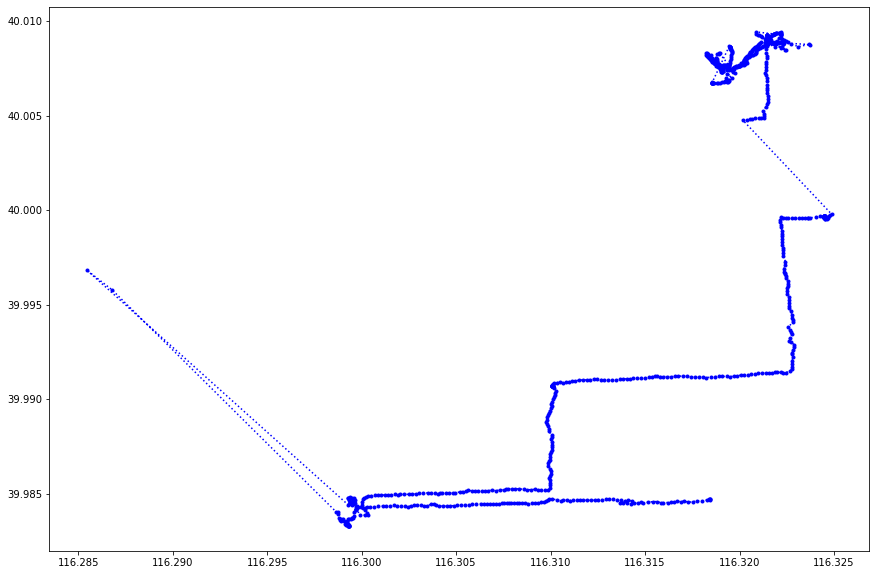

In [12]:
plt.figure(figsize=(18, 10))
plt.gca().set_aspect("equal")
plt.plot(data_pd["longitude"], data_pd["latitude"], 'b.:')
plt.show()

Looks kind of messy. There's also some rando outlier points in there. That's kind of awkward, but can't really be helped.

### All trajectories for one person

Now let's try concatenating all the trajectories together into one big path.

In [14]:
# import some libraries
import glob


In [20]:
# construct our dataframe
data_dict = {"latitude":[], "longitude":[], "time":[]}
for file_path in glob.iglob(r'Geolife Trajectories 1.3/Data/000/Trajectory/*.plt'):
    data_np = np.genfromtxt(file_path, delimiter=',', skip_header=6, usecols=[0, 1, 4])
    data_dict['latitude'] += [lat for lat in data_np[:, 0]]
    data_dict['longitude'] += [lon for lon in data_np[:, 1]]
    data_dict['time'] += [tim for tim in data_np[:, 2]]
data_df = pd.DataFrame(data_dict)


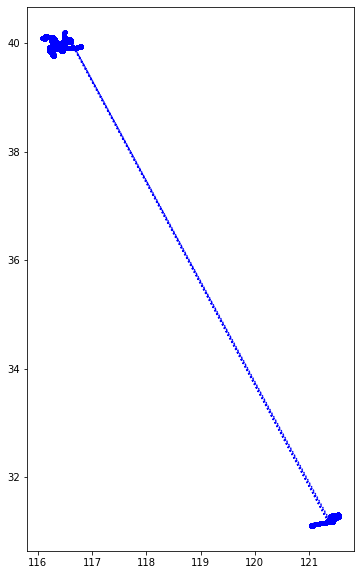

In [24]:
# sort our data by time and then plot it out
data_df = data_df.sort_values("time")

plt.figure(figsize=(18, 10))
plt.gca().set_aspect("equal")
plt.plot(data_df["longitude"], data_df["latitude"], 'b.:')
plt.show()


Hmm... We see that this person just decides to go visit somewhere for awhile before coming back, which is unfortunate because I don't want to simulate such a large range. What if we limit the location based on the 5th Ring Road thing? Looking at Figure 1B in the Geolife User Guide, this should be a longitude from 116.18 to 116.57 and a latitude from 39.75 to 40.10. 

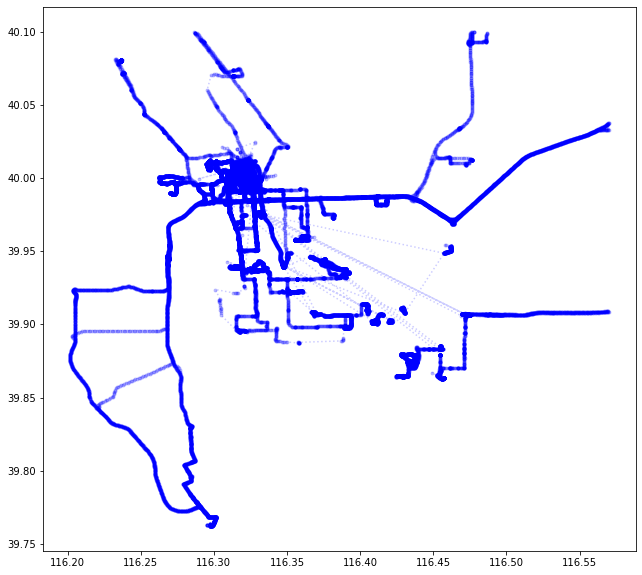

In [27]:
# limit the data and plot it again
small_df = data_df.loc[(data_df["longitude"] > 116.18) & 
                       (data_df["longitude"] < 116.57) &
                       (data_df["latitude"] > 39.75) &
                       (data_df["latitude"] < 40.10)]

plt.figure(figsize=(18, 10))
plt.gca().set_aspect("equal")
plt.plot(small_df["longitude"], small_df["latitude"], 'b.:', alpha=0.2)
plt.show()

Oo that's pretty fun! I think we can work with that. Now... what do we do about time?

In [35]:
# see the total time span of this data in days
small_df["time"].iloc[len(small_df)-1] - small_df["time"].iloc[0]


255.2029050925994

In [37]:
small_df["time_diff"] = small_df.diff()["time"]

<ipython-input-37-9254ac6f60fc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df["time_diff"] = small_df.diff()["time"]


In [38]:
small_df.head()

latitude   longitude          time  time_diff
64312  39.984702  116.318417  39744.120185        NaN
64313  39.984683  116.318450  39744.120255   0.000069
64314  39.984686  116.318417  39744.120313   0.000058
64315  39.984688  116.318385  39744.120370   0.000058
64316  39.984655  116.318263  39744.120428   0.000058

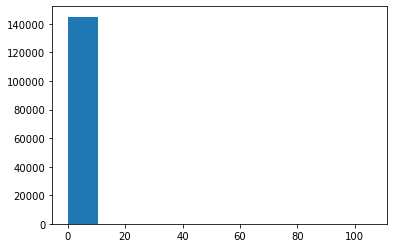

(array([1.45017e+05, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
       0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]), array([1.15739967e-05, 1.05977616e+01, 2.11955116e+01, 3.17932616e+01,
       4.23910116e+01, 5.29887616e+01, 6.35865116e+01, 7.41842616e+01,
       8.47820116e+01, 9.53797616e+01, 1.05977512e+02]), <a list of 10 Patch objects>)


In [43]:
plt.figure()
vals = plt.hist(small_df["time_diff"].iloc[1:])
plt.show()
print(vals)

In [46]:
np.percentile(small_df["time_diff"].iloc[1:], [50, 95, 98, 99, 100])

array([5.78703985e-05, 5.78704057e-05, 5.78704057e-05, 1.73611101e-04,
       1.05977512e+02])

It seems like the vast majority of the data is taken sequentially (which makes sense) with only a few jumps between recording times, so maybe we can just trim those out and normalize time to start at 0 and call it a day.

In [58]:
diff_cap = np.percentile(small_df["time_diff"].iloc[1:], 99)
small_df["cap_diff"] = small_df["time_diff"].clip(upper=diff_cap).fillna(0)

<ipython-input-58-d12cde901645>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df["cap_diff"] = small_df["time_diff"].clip(upper=diff_cap).fillna(0)


In [59]:
small_df.head()

latitude   longitude          time  time_diff  cap_diff  norm_time
64312  39.984702  116.318417  39744.120185        NaN  0.000000        NaN
64313  39.984683  116.318450  39744.120255   0.000069  0.000069   0.000069
64314  39.984686  116.318417  39744.120313   0.000058  0.000058   0.000127
64315  39.984688  116.318385  39744.120370   0.000058  0.000058   0.000185
64316  39.984655  116.318263  39744.120428   0.000058  0.000058   0.000243

In [60]:
small_df["norm_time"] = small_df["cap_diff"].cumsum()

<ipython-input-60-58e9c1437c88>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_df["norm_time"] = small_df["cap_diff"].cumsum()


In [61]:
small_df.head()

latitude   longitude          time  time_diff  cap_diff  norm_time
64312  39.984702  116.318417  39744.120185        NaN  0.000000   0.000000
64313  39.984683  116.318450  39744.120255   0.000069  0.000069   0.000069
64314  39.984686  116.318417  39744.120313   0.000058  0.000058   0.000127
64315  39.984688  116.318385  39744.120370   0.000058  0.000058   0.000185
64316  39.984655  116.318263  39744.120428   0.000058  0.000058   0.000243

In [63]:
small_df.tail()

latitude   longitude          time  time_diff  cap_diff  norm_time
18371  40.000403  116.327255  39999.322859   0.000058  0.000058   8.199213
18372  40.000433  116.327209  39999.322917   0.000058  0.000058   8.199271
18373  40.000443  116.327186  39999.322975   0.000058  0.000058   8.199329
18374  40.000522  116.327132  39999.323032   0.000058  0.000058   8.199387
18375  40.000543  116.327148  39999.323090   0.000058  0.000058   8.199444

Nice! Now the modeled trajectory only takes 8 days to complete. While this is still a little long (and will be terrible to simulate), this is significantly more reasonable than the original 255 days worth of trajectories!

## Repeat for all of the other people

Now we just do the same thing for everyone else and see what we get!

In [ ]:
# import libraries
import glob
import numpy as np
import pandas as pd


In [86]:
dir_path = r'Geolife Trajectories 1.3/Data/*'
big_dict = {}

lon_min = 116.18
lon_max = 116.57
lat_min = 39.75
lat_max = 40.10

# Construct the filtered and re-timed dataframe for each person.
for person_dir in glob.iglob(dir_path):
    # Load the trajectories into a dataframe.
    data_dict = {"latitude":[], "longitude":[], "time":[]}
    for file_path in glob.iglob(r"{}/Trajectory/*.plt".format(person_dir)):
        data_np = np.genfromtxt(file_path, delimiter=',', skip_header=6, usecols=[0, 1, 4])
        data_dict['latitude'] += [lat for lat in data_np[:, 0]]
        data_dict['longitude'] += [lon for lon in data_np[:, 1]]
        data_dict['time'] += [tim for tim in data_np[:, 2]]
    data_df = pd.DataFrame(data_dict)
    
    # Filter the latitude and longitude values to be around the 5th Ring Road of Beijing.
    small_df = data_df.loc[(data_df["longitude"] > 116.18) & 
                           (data_df["longitude"] < 116.57) &
                           (data_df["latitude"] > 39.75) &
                           (data_df["latitude"] < 40.10)]

    # If the GPS values were all recorded outside of Beijing, small_df will be empty here.
    # For now, we will ignore all people who didn't collect any trajectory data in Beijing.
    if len(small_df) <= 0:
        continue
    
    # Finagle the time to remove all gaps in data collection.
    small_df = small_df.sort_values("time")
    small_df["time_diff"] = small_df.diff()["time"]
    diff_cap = np.percentile(small_df["time_diff"].iloc[1:], 99) # Avoid distorting our data as much as possible.
    small_df["cap_diff"] = small_df["time_diff"].clip(upper=diff_cap).fillna(0)
    small_df["norm_time"] = small_df["cap_diff"].cumsum()
    
    # Add the new dataframe to our big_dict.
    person_id = person_dir.split('/')[-1]
    big_dict[person_id] = small_df
    

Geolife Trajectories 1.3/Data/135/Trajectory/20090103012134.plt
Geolife Trajectories 1.3/Data/135/Trajectory/20090102043127.plt
Geolife Trajectories 1.3/Data/135/Trajectory/20090127030004.plt
Geolife Trajectories 1.3/Data/135/Trajectory/20090110011947.plt
Geolife Trajectories 1.3/Data/135/Trajectory/20081227072604.plt
Geolife Trajectories 1.3/Data/135/Trajectory/20090101024458.plt
Geolife Trajectories 1.3/Data/135/Trajectory/20090114121757.plt
Geolife Trajectories 1.3/Data/135/Trajectory/20090112014122.plt
Geolife Trajectories 1.3/Data/135/Trajectory/20090124065103.plt
Geolife Trajectories 1.3/Data/135/Trajectory/20090126022633.plt
Geolife Trajectories 1.3/Data/135/Trajectory/20081224144207.plt
Geolife Trajectories 1.3/Data/135/Trajectory/20081228103605.plt
Geolife Trajectories 1.3/Data/135/Trajectory/20090109130304.plt
Geolife Trajectories 1.3/Data/132/Trajectory/20100215105635.plt
Geolife Trajectories 1.3/Data/132/Trajectory/20100217105258.plt
Geolife Trajectories 1.3/Data/132/Trajec

Geolife Trajectories 1.3/Data/103/Trajectory/20080917110637.plt
Geolife Trajectories 1.3/Data/103/Trajectory/20080903075657.plt
Geolife Trajectories 1.3/Data/103/Trajectory/20080905041948.plt
Geolife Trajectories 1.3/Data/103/Trajectory/20080919092921.plt
Geolife Trajectories 1.3/Data/103/Trajectory/20080920061016.plt
Geolife Trajectories 1.3/Data/103/Trajectory/20080828100139.plt
Geolife Trajectories 1.3/Data/103/Trajectory/20080827055541.plt
Geolife Trajectories 1.3/Data/103/Trajectory/20080908134118.plt
Geolife Trajectories 1.3/Data/103/Trajectory/20080908051356.plt
Geolife Trajectories 1.3/Data/103/Trajectory/20080909092430.plt
Geolife Trajectories 1.3/Data/103/Trajectory/20080908100521.plt
Geolife Trajectories 1.3/Data/103/Trajectory/20080904082756.plt
Geolife Trajectories 1.3/Data/103/Trajectory/20080911123312.plt
Geolife Trajectories 1.3/Data/103/Trajectory/20080905093145.plt
Geolife Trajectories 1.3/Data/103/Trajectory/20080917231611.plt
Geolife Trajectories 1.3/Data/103/Trajec

Geolife Trajectories 1.3/Data/150/Trajectory/20070807095135.plt
Geolife Trajectories 1.3/Data/150/Trajectory/20070809003606.plt
Geolife Trajectories 1.3/Data/150/Trajectory/20070804040103.plt
Geolife Trajectories 1.3/Data/150/Trajectory/20070731233347.plt
Geolife Trajectories 1.3/Data/150/Trajectory/20070802001931.plt
Geolife Trajectories 1.3/Data/150/Trajectory/20070806234009.plt
Geolife Trajectories 1.3/Data/150/Trajectory/20070801111718.plt
Geolife Trajectories 1.3/Data/150/Trajectory/20070803083803.plt
Geolife Trajectories 1.3/Data/150/Trajectory/20070802153301.plt
Geolife Trajectories 1.3/Data/150/Trajectory/20070810095141.plt
Geolife Trajectories 1.3/Data/150/Trajectory/20070805232735.plt
Geolife Trajectories 1.3/Data/150/Trajectory/20070803084029.plt
Geolife Trajectories 1.3/Data/150/Trajectory/20070806235137.plt
Geolife Trajectories 1.3/Data/150/Trajectory/20070808100315.plt
Geolife Trajectories 1.3/Data/150/Trajectory/20070801145802.plt
Geolife Trajectories 1.3/Data/150/Trajec

Geolife Trajectories 1.3/Data/160/Trajectory/20101228070228.plt
Geolife Trajectories 1.3/Data/160/Trajectory/20101227095821.plt
Geolife Trajectories 1.3/Data/158/Trajectory/20090124014752.plt
Geolife Trajectories 1.3/Data/158/Trajectory/20090123102806.plt
Geolife Trajectories 1.3/Data/158/Trajectory/20090207092106.plt
Geolife Trajectories 1.3/Data/158/Trajectory/20090121010001.plt
Geolife Trajectories 1.3/Data/158/Trajectory/20090128051557.plt
Geolife Trajectories 1.3/Data/158/Trajectory/20090127062524.plt
Geolife Trajectories 1.3/Data/158/Trajectory/20090120010934.plt
Geolife Trajectories 1.3/Data/158/Trajectory/20090213113535.plt
Geolife Trajectories 1.3/Data/158/Trajectory/20090122012207.plt
Geolife Trajectories 1.3/Data/158/Trajectory/20090218013406.plt
Geolife Trajectories 1.3/Data/158/Trajectory/20090116082005.plt
Geolife Trajectories 1.3/Data/158/Trajectory/20090304094335.plt
Geolife Trajectories 1.3/Data/158/Trajectory/20090119041551.plt
Geolife Trajectories 1.3/Data/158/Trajec

Geolife Trajectories 1.3/Data/167/Trajectory/20080818083607.plt
Geolife Trajectories 1.3/Data/167/Trajectory/20080401032546.plt
Geolife Trajectories 1.3/Data/167/Trajectory/20080701013935.plt
Geolife Trajectories 1.3/Data/167/Trajectory/20080626110059.plt
Geolife Trajectories 1.3/Data/167/Trajectory/20090128035001.plt
Geolife Trajectories 1.3/Data/167/Trajectory/20080323093410.plt
Geolife Trajectories 1.3/Data/167/Trajectory/20080518055205.plt
Geolife Trajectories 1.3/Data/167/Trajectory/20080402001631.plt
Geolife Trajectories 1.3/Data/167/Trajectory/20080929001429.plt
Geolife Trajectories 1.3/Data/167/Trajectory/20080819144129.plt
Geolife Trajectories 1.3/Data/167/Trajectory/20080915070255.plt
Geolife Trajectories 1.3/Data/167/Trajectory/20080617082022.plt
Geolife Trajectories 1.3/Data/167/Trajectory/20080407003029.plt
Geolife Trajectories 1.3/Data/167/Trajectory/20080408012548.plt
Geolife Trajectories 1.3/Data/167/Trajectory/20080610172835.plt
Geolife Trajectories 1.3/Data/167/Trajec

Geolife Trajectories 1.3/Data/167/Trajectory/20081215092501.plt
Geolife Trajectories 1.3/Data/167/Trajectory/20081221091056.plt
Geolife Trajectories 1.3/Data/167/Trajectory/20090207004237.plt
Geolife Trajectories 1.3/Data/167/Trajectory/20081024010406.plt
Geolife Trajectories 1.3/Data/167/Trajectory/20080621164500.plt
Geolife Trajectories 1.3/Data/167/Trajectory/20081013032424.plt
Geolife Trajectories 1.3/Data/167/Trajectory/20080513162952.plt
Geolife Trajectories 1.3/Data/167/Trajectory/20090121064258.plt
Geolife Trajectories 1.3/Data/167/Trajectory/20080810013852.plt
Geolife Trajectories 1.3/Data/167/Trajectory/20081122143235.plt
Geolife Trajectories 1.3/Data/167/Trajectory/20080321094557.plt
Geolife Trajectories 1.3/Data/167/Trajectory/20080920055722.plt
Geolife Trajectories 1.3/Data/167/Trajectory/20080430013834.plt
Geolife Trajectories 1.3/Data/167/Trajectory/20081120021036.plt
Geolife Trajectories 1.3/Data/167/Trajectory/20080320004131.plt
Geolife Trajectories 1.3/Data/167/Trajec

Geolife Trajectories 1.3/Data/024/Trajectory/20090323232430.plt
Geolife Trajectories 1.3/Data/024/Trajectory/20090321235532.plt
Geolife Trajectories 1.3/Data/024/Trajectory/20090214014932.plt
Geolife Trajectories 1.3/Data/024/Trajectory/20090319232505.plt
Geolife Trajectories 1.3/Data/024/Trajectory/20090202050504.plt
Geolife Trajectories 1.3/Data/024/Trajectory/20081218040703.plt
Geolife Trajectories 1.3/Data/024/Trajectory/20090219043937.plt
Geolife Trajectories 1.3/Data/024/Trajectory/20090304091131.plt
Geolife Trajectories 1.3/Data/024/Trajectory/20090522012954.plt
Geolife Trajectories 1.3/Data/024/Trajectory/20090218010935.plt
Geolife Trajectories 1.3/Data/024/Trajectory/20090128022508.plt
Geolife Trajectories 1.3/Data/024/Trajectory/20081217011026.plt
Geolife Trajectories 1.3/Data/024/Trajectory/20090221003755.plt
Geolife Trajectories 1.3/Data/024/Trajectory/20090519231433.plt
Geolife Trajectories 1.3/Data/024/Trajectory/20090318010336.plt
Geolife Trajectories 1.3/Data/024/Trajec

Geolife Trajectories 1.3/Data/015/Trajectory/20081119103250.plt
Geolife Trajectories 1.3/Data/015/Trajectory/20081029234627.plt
Geolife Trajectories 1.3/Data/015/Trajectory/20090228174757.plt
Geolife Trajectories 1.3/Data/015/Trajectory/20081112144903.plt
Geolife Trajectories 1.3/Data/015/Trajectory/20090226225533.plt
Geolife Trajectories 1.3/Data/015/Trajectory/20081028091541.plt
Geolife Trajectories 1.3/Data/015/Trajectory/20090302164004.plt
Geolife Trajectories 1.3/Data/015/Trajectory/20090301224903.plt
Geolife Trajectories 1.3/Data/015/Trajectory/20081111091003.plt
Geolife Trajectories 1.3/Data/015/Trajectory/20081120094704.plt
Geolife Trajectories 1.3/Data/015/Trajectory/20081106093839.plt
Geolife Trajectories 1.3/Data/015/Trajectory/20081030234536.plt
Geolife Trajectories 1.3/Data/015/Trajectory/20081105233035.plt
Geolife Trajectories 1.3/Data/015/Trajectory/20081112000936.plt
Geolife Trajectories 1.3/Data/015/Trajectory/20081102235805.plt
Geolife Trajectories 1.3/Data/015/Trajec

Geolife Trajectories 1.3/Data/046/Trajectory/20091005022823.plt
Geolife Trajectories 1.3/Data/046/Trajectory/20100514013459.plt
Geolife Trajectories 1.3/Data/046/Trajectory/20100602003336.plt
Geolife Trajectories 1.3/Data/046/Trajectory/20100527101930.plt
Geolife Trajectories 1.3/Data/046/Trajectory/20100519002637.plt
Geolife Trajectories 1.3/Data/046/Trajectory/20100601111507.plt
Geolife Trajectories 1.3/Data/046/Trajectory/20100514102803.plt
Geolife Trajectories 1.3/Data/046/Trajectory/20100512003259.plt
Geolife Trajectories 1.3/Data/046/Trajectory/20100520120036.plt
Geolife Trajectories 1.3/Data/046/Trajectory/20100508042031.plt
Geolife Trajectories 1.3/Data/046/Trajectory/20100513005525.plt
Geolife Trajectories 1.3/Data/046/Trajectory/20100507103627.plt
Geolife Trajectories 1.3/Data/046/Trajectory/20100518105736.plt
Geolife Trajectories 1.3/Data/046/Trajectory/20091009124618.plt
Geolife Trajectories 1.3/Data/046/Trajectory/20100518003231.plt
Geolife Trajectories 1.3/Data/046/Trajec

Geolife Trajectories 1.3/Data/041/Trajectory/20090403042115.plt
Geolife Trajectories 1.3/Data/041/Trajectory/20090611025235.plt
Geolife Trajectories 1.3/Data/041/Trajectory/20090531103156.plt
Geolife Trajectories 1.3/Data/041/Trajectory/20090630222720.plt
Geolife Trajectories 1.3/Data/041/Trajectory/20090305044141.plt
Geolife Trajectories 1.3/Data/041/Trajectory/20090615025717.plt
Geolife Trajectories 1.3/Data/041/Trajectory/20090222223334.plt
Geolife Trajectories 1.3/Data/041/Trajectory/20090402000743.plt
Geolife Trajectories 1.3/Data/041/Trajectory/20090304053502.plt
Geolife Trajectories 1.3/Data/041/Trajectory/20090415023025.plt
Geolife Trajectories 1.3/Data/041/Trajectory/20090424085704.plt
Geolife Trajectories 1.3/Data/041/Trajectory/20090216221838.plt
Geolife Trajectories 1.3/Data/041/Trajectory/20090227100016.plt
Geolife Trajectories 1.3/Data/041/Trajectory/20090414085454.plt
Geolife Trajectories 1.3/Data/041/Trajectory/20090319092133.plt
Geolife Trajectories 1.3/Data/041/Trajec

Geolife Trajectories 1.3/Data/041/Trajectory/20090222233151.plt
Geolife Trajectories 1.3/Data/041/Trajectory/20090422100145.plt
Geolife Trajectories 1.3/Data/041/Trajectory/20090622114717.plt
Geolife Trajectories 1.3/Data/041/Trajectory/20090421221320.plt
Geolife Trajectories 1.3/Data/041/Trajectory/20090619093910.plt
Geolife Trajectories 1.3/Data/041/Trajectory/20090623051609.plt
Geolife Trajectories 1.3/Data/041/Trajectory/20090420215421.plt
Geolife Trajectories 1.3/Data/041/Trajectory/20090223074838.plt
Geolife Trajectories 1.3/Data/041/Trajectory/20090530090136.plt
Geolife Trajectories 1.3/Data/041/Trajectory/20090614220036.plt
Geolife Trajectories 1.3/Data/041/Trajectory/20090518101655.plt
Geolife Trajectories 1.3/Data/041/Trajectory/20090618055854.plt
Geolife Trajectories 1.3/Data/041/Trajectory/20090307030439.plt
Geolife Trajectories 1.3/Data/041/Trajectory/20090427044507.plt
Geolife Trajectories 1.3/Data/041/Trajectory/20090408150236.plt
Geolife Trajectories 1.3/Data/041/Trajec

Geolife Trajectories 1.3/Data/041/Trajectory/20090617071645.plt
Geolife Trajectories 1.3/Data/041/Trajectory/20090507094211.plt
Geolife Trajectories 1.3/Data/041/Trajectory/20090410092835.plt
Geolife Trajectories 1.3/Data/041/Trajectory/20090408024715.plt
Geolife Trajectories 1.3/Data/041/Trajectory/20090702232326.plt
Geolife Trajectories 1.3/Data/041/Trajectory/20090223223159.plt
Geolife Trajectories 1.3/Data/041/Trajectory/20090611092335.plt
Geolife Trajectories 1.3/Data/041/Trajectory/20090526222325.plt
Geolife Trajectories 1.3/Data/041/Trajectory/20090514053139.plt
Geolife Trajectories 1.3/Data/041/Trajectory/20090305014814.plt
Geolife Trajectories 1.3/Data/041/Trajectory/20090226005048.plt
Geolife Trajectories 1.3/Data/041/Trajectory/20090412224823.plt
Geolife Trajectories 1.3/Data/041/Trajectory/20090710092700.plt
Geolife Trajectories 1.3/Data/041/Trajectory/20090702073937.plt
Geolife Trajectories 1.3/Data/041/Trajectory/20090525090447.plt
Geolife Trajectories 1.3/Data/041/Trajec

Geolife Trajectories 1.3/Data/048/Trajectory/20090902130106.plt
Geolife Trajectories 1.3/Data/048/Trajectory/20090904092333.plt
Geolife Trajectories 1.3/Data/048/Trajectory/20090903184534.plt
Geolife Trajectories 1.3/Data/077/Trajectory/20090920123345.plt
Geolife Trajectories 1.3/Data/077/Trajectory/20090920104403.plt
Geolife Trajectories 1.3/Data/077/Trajectory/20090919133234.plt
Geolife Trajectories 1.3/Data/083/Trajectory/20090306082719.plt
Geolife Trajectories 1.3/Data/083/Trajectory/20090922233909.plt
Geolife Trajectories 1.3/Data/083/Trajectory/20090112220255.plt
Geolife Trajectories 1.3/Data/083/Trajectory/20090923231944.plt
Geolife Trajectories 1.3/Data/083/Trajectory/20090108214517.plt
Geolife Trajectories 1.3/Data/083/Trajectory/20090915092242.plt
Geolife Trajectories 1.3/Data/083/Trajectory/20090127125634.plt
Geolife Trajectories 1.3/Data/083/Trajectory/20090219214425.plt
Geolife Trajectories 1.3/Data/083/Trajectory/20090109224936.plt
Geolife Trajectories 1.3/Data/083/Trajec

Geolife Trajectories 1.3/Data/084/Trajectory/20081015003135.plt
Geolife Trajectories 1.3/Data/084/Trajectory/20090409001837.plt
Geolife Trajectories 1.3/Data/084/Trajectory/20080819231929.plt
Geolife Trajectories 1.3/Data/084/Trajectory/20081016104337.plt
Geolife Trajectories 1.3/Data/084/Trajectory/20081102022639.plt
Geolife Trajectories 1.3/Data/084/Trajectory/20090509093255.plt
Geolife Trajectories 1.3/Data/084/Trajectory/20090426235937.plt
Geolife Trajectories 1.3/Data/084/Trajectory/20090531011903.plt
Geolife Trajectories 1.3/Data/084/Trajectory/20081031034225.plt
Geolife Trajectories 1.3/Data/084/Trajectory/20090518083303.plt
Geolife Trajectories 1.3/Data/084/Trajectory/20090503145258.plt
Geolife Trajectories 1.3/Data/084/Trajectory/20081126115500.plt
Geolife Trajectories 1.3/Data/084/Trajectory/20090525142036.plt
Geolife Trajectories 1.3/Data/084/Trajectory/20080918235405.plt
Geolife Trajectories 1.3/Data/084/Trajectory/20080925082636.plt
Geolife Trajectories 1.3/Data/084/Trajec

Geolife Trajectories 1.3/Data/013/Trajectory/20090201104629.plt
Geolife Trajectories 1.3/Data/013/Trajectory/20081209121123.plt
Geolife Trajectories 1.3/Data/013/Trajectory/20081020232134.plt
Geolife Trajectories 1.3/Data/013/Trajectory/20081105092059.plt
Geolife Trajectories 1.3/Data/013/Trajectory/20080929224313.plt
Geolife Trajectories 1.3/Data/013/Trajectory/20081018021735.plt
Geolife Trajectories 1.3/Data/013/Trajectory/20081031005659.plt
Geolife Trajectories 1.3/Data/013/Trajectory/20081029221534.plt
Geolife Trajectories 1.3/Data/013/Trajectory/20081008232207.plt
Geolife Trajectories 1.3/Data/013/Trajectory/20081017093105.plt
Geolife Trajectories 1.3/Data/013/Trajectory/20090217092623.plt
Geolife Trajectories 1.3/Data/013/Trajectory/20081024221335.plt
Geolife Trajectories 1.3/Data/013/Trajectory/20090126052958.plt
Geolife Trajectories 1.3/Data/013/Trajectory/20090117090122.plt
Geolife Trajectories 1.3/Data/013/Trajectory/20081110231659.plt
Geolife Trajectories 1.3/Data/013/Trajec

Geolife Trajectories 1.3/Data/014/Trajectory/20081221031834.plt
Geolife Trajectories 1.3/Data/014/Trajectory/20081217071404.plt
Geolife Trajectories 1.3/Data/014/Trajectory/20090407231100.plt
Geolife Trajectories 1.3/Data/014/Trajectory/20081214235235.plt
Geolife Trajectories 1.3/Data/014/Trajectory/20090124012336.plt
Geolife Trajectories 1.3/Data/014/Trajectory/20081206013107.plt
Geolife Trajectories 1.3/Data/014/Trajectory/20090417013836.plt
Geolife Trajectories 1.3/Data/014/Trajectory/20081030035117.plt
Geolife Trajectories 1.3/Data/014/Trajectory/20081105124707.plt
Geolife Trajectories 1.3/Data/014/Trajectory/20081025080903.plt
Geolife Trajectories 1.3/Data/014/Trajectory/20081223235303.plt
Geolife Trajectories 1.3/Data/014/Trajectory/20090213005445.plt
Geolife Trajectories 1.3/Data/014/Trajectory/20081210235310.plt
Geolife Trajectories 1.3/Data/014/Trajectory/20090302003444.plt
Geolife Trajectories 1.3/Data/014/Trajectory/20081114073137.plt
Geolife Trajectories 1.3/Data/014/Trajec

Geolife Trajectories 1.3/Data/014/Trajectory/20090211003814.plt
Geolife Trajectories 1.3/Data/014/Trajectory/20090117022930.plt
Geolife Trajectories 1.3/Data/014/Trajectory/20081117072920.plt
Geolife Trajectories 1.3/Data/014/Trajectory/20081107081230.plt
Geolife Trajectories 1.3/Data/014/Trajectory/20090209045015.plt
Geolife Trajectories 1.3/Data/014/Trajectory/20090128032204.plt
Geolife Trajectories 1.3/Data/014/Trajectory/20081025093121.plt
Geolife Trajectories 1.3/Data/014/Trajectory/20081129061408.plt
Geolife Trajectories 1.3/Data/014/Trajectory/20090210001536.plt
Geolife Trajectories 1.3/Data/014/Trajectory/20090413234415.plt
Geolife Trajectories 1.3/Data/014/Trajectory/20090116014039.plt
Geolife Trajectories 1.3/Data/014/Trajectory/20090120003809.plt
Geolife Trajectories 1.3/Data/014/Trajectory/20090415002736.plt
Geolife Trajectories 1.3/Data/014/Trajectory/20081127234447.plt
Geolife Trajectories 1.3/Data/014/Trajectory/20090403070254.plt
Geolife Trajectories 1.3/Data/014/Trajec

Geolife Trajectories 1.3/Data/022/Trajectory/20090513041800.plt
Geolife Trajectories 1.3/Data/022/Trajectory/20090426121143.plt
Geolife Trajectories 1.3/Data/022/Trajectory/20090427052253.plt
Geolife Trajectories 1.3/Data/022/Trajectory/20090528111033.plt
Geolife Trajectories 1.3/Data/022/Trajectory/20090310124822.plt
Geolife Trajectories 1.3/Data/022/Trajectory/20090426120923.plt
Geolife Trajectories 1.3/Data/022/Trajectory/20090207092704.plt
Geolife Trajectories 1.3/Data/022/Trajectory/20090117223222.plt
Geolife Trajectories 1.3/Data/022/Trajectory/20090210010335.plt
Geolife Trajectories 1.3/Data/022/Trajectory/20090511000217.plt
Geolife Trajectories 1.3/Data/022/Trajectory/20090617030954.plt
Geolife Trajectories 1.3/Data/022/Trajectory/20090608001025.plt
Geolife Trajectories 1.3/Data/022/Trajectory/20090311012103.plt
Geolife Trajectories 1.3/Data/022/Trajectory/20090212103652.plt
Geolife Trajectories 1.3/Data/022/Trajectory/20090120212134.plt
Geolife Trajectories 1.3/Data/022/Trajec

Geolife Trajectories 1.3/Data/022/Trajectory/20090706070306.plt
Geolife Trajectories 1.3/Data/022/Trajectory/20090422011155.plt
Geolife Trajectories 1.3/Data/022/Trajectory/20090505235557.plt
Geolife Trajectories 1.3/Data/022/Trajectory/20090308083628.plt
Geolife Trajectories 1.3/Data/022/Trajectory/20090320121232.plt
Geolife Trajectories 1.3/Data/022/Trajectory/20090723013354.plt
Geolife Trajectories 1.3/Data/022/Trajectory/20090630002904.plt
Geolife Trajectories 1.3/Data/022/Trajectory/20090721234300.plt
Geolife Trajectories 1.3/Data/022/Trajectory/20090609232837.plt
Geolife Trajectories 1.3/Data/022/Trajectory/20090502044205.plt
Geolife Trajectories 1.3/Data/025/Trajectory/20090311005736.plt
Geolife Trajectories 1.3/Data/025/Trajectory/20090626142016.plt
Geolife Trajectories 1.3/Data/025/Trajectory/20090130055525.plt
Geolife Trajectories 1.3/Data/025/Trajectory/20090427073935.plt
Geolife Trajectories 1.3/Data/025/Trajectory/20090409000408.plt
Geolife Trajectories 1.3/Data/025/Trajec

Geolife Trajectories 1.3/Data/025/Trajectory/20090702091404.plt
Geolife Trajectories 1.3/Data/025/Trajectory/20081221070930.plt
Geolife Trajectories 1.3/Data/025/Trajectory/20090123074212.plt
Geolife Trajectories 1.3/Data/025/Trajectory/20090416104524.plt
Geolife Trajectories 1.3/Data/025/Trajectory/20090402070448.plt
Geolife Trajectories 1.3/Data/025/Trajectory/20090118054057.plt
Geolife Trajectories 1.3/Data/025/Trajectory/20090412101430.plt
Geolife Trajectories 1.3/Data/025/Trajectory/20090309114930.plt
Geolife Trajectories 1.3/Data/025/Trajectory/20090502224636.plt
Geolife Trajectories 1.3/Data/025/Trajectory/20090622092840.plt
Geolife Trajectories 1.3/Data/025/Trajectory/20090210081007.plt
Geolife Trajectories 1.3/Data/025/Trajectory/20090528043016.plt
Geolife Trajectories 1.3/Data/025/Trajectory/20090314033853.plt
Geolife Trajectories 1.3/Data/025/Trajectory/20090620092630.plt
Geolife Trajectories 1.3/Data/025/Trajectory/20090526235709.plt
Geolife Trajectories 1.3/Data/025/Trajec

Geolife Trajectories 1.3/Data/025/Trajectory/20090504114112.plt
Geolife Trajectories 1.3/Data/025/Trajectory/20090331013636.plt
Geolife Trajectories 1.3/Data/025/Trajectory/20090216013306.plt
Geolife Trajectories 1.3/Data/025/Trajectory/20090330093444.plt
Geolife Trajectories 1.3/Data/025/Trajectory/20090305130932.plt
Geolife Trajectories 1.3/Data/025/Trajectory/20090319121600.plt
Geolife Trajectories 1.3/Data/025/Trajectory/20090505122944.plt
Geolife Trajectories 1.3/Data/025/Trajectory/20090312010036.plt
Geolife Trajectories 1.3/Data/025/Trajectory/20090708112912.plt
Geolife Trajectories 1.3/Data/025/Trajectory/20090322014538.plt
Geolife Trajectories 1.3/Data/025/Trajectory/20090208061443.plt
Geolife Trajectories 1.3/Data/025/Trajectory/20090212121332.plt
Geolife Trajectories 1.3/Data/025/Trajectory/20081225093332.plt
Geolife Trajectories 1.3/Data/025/Trajectory/20090428001837.plt
Geolife Trajectories 1.3/Data/025/Trajectory/20081216010001.plt
Geolife Trajectories 1.3/Data/025/Trajec

Geolife Trajectories 1.3/Data/025/Trajectory/20090121074951.plt
Geolife Trajectories 1.3/Data/025/Trajectory/20081224041141.plt
Geolife Trajectories 1.3/Data/025/Trajectory/20090403045558.plt
Geolife Trajectories 1.3/Data/025/Trajectory/20090520234651.plt
Geolife Trajectories 1.3/Data/025/Trajectory/20090408111938.plt
Geolife Trajectories 1.3/Data/025/Trajectory/20090213123348.plt
Geolife Trajectories 1.3/Data/025/Trajectory/20090419111710.plt
Geolife Trajectories 1.3/Data/025/Trajectory/20090423123244.plt
Geolife Trajectories 1.3/Data/025/Trajectory/20081222073056.plt
Geolife Trajectories 1.3/Data/025/Trajectory/20090217054344.plt
Geolife Trajectories 1.3/Data/025/Trajectory/20090104120001.plt
Geolife Trajectories 1.3/Data/025/Trajectory/20090612064142.plt
Geolife Trajectories 1.3/Data/025/Trajectory/20090414062501.plt
Geolife Trajectories 1.3/Data/025/Trajectory/20090319012002.plt
Geolife Trajectories 1.3/Data/025/Trajectory/20090711073706.plt
Geolife Trajectories 1.3/Data/025/Trajec

Geolife Trajectories 1.3/Data/025/Trajectory/20090206120053.plt
Geolife Trajectories 1.3/Data/025/Trajectory/20090525000736.plt
Geolife Trajectories 1.3/Data/025/Trajectory/20090115123808.plt
Geolife Trajectories 1.3/Data/025/Trajectory/20090517092755.plt
Geolife Trajectories 1.3/Data/025/Trajectory/20090514000001.plt
Geolife Trajectories 1.3/Data/025/Trajectory/20090312123859.plt
Geolife Trajectories 1.3/Data/025/Trajectory/20090309092208.plt
Geolife Trajectories 1.3/Data/025/Trajectory/20090429091814.plt
Geolife Trajectories 1.3/Data/025/Trajectory/20090524075447.plt
Geolife Trajectories 1.3/Data/025/Trajectory/20090708020049.plt
Geolife Trajectories 1.3/Data/025/Trajectory/20090108054345.plt
Geolife Trajectories 1.3/Data/025/Trajectory/20090208115140.plt
Geolife Trajectories 1.3/Data/025/Trajectory/20090620001440.plt
Geolife Trajectories 1.3/Data/025/Trajectory/20081225075347.plt
Geolife Trajectories 1.3/Data/025/Trajectory/20090414065032.plt
Geolife Trajectories 1.3/Data/025/Trajec

Geolife Trajectories 1.3/Data/085/Trajectory/20081216001223.plt
Geolife Trajectories 1.3/Data/085/Trajectory/20090831113328.plt
Geolife Trajectories 1.3/Data/085/Trajectory/20090512114928.plt
Geolife Trajectories 1.3/Data/085/Trajectory/20090421102505.plt
Geolife Trajectories 1.3/Data/085/Trajectory/20080725025430.plt
Geolife Trajectories 1.3/Data/085/Trajectory/20080527224904.plt
Geolife Trajectories 1.3/Data/085/Trajectory/20090918103558.plt
Geolife Trajectories 1.3/Data/085/Trajectory/20090915235904.plt
Geolife Trajectories 1.3/Data/085/Trajectory/20080514223658.plt
Geolife Trajectories 1.3/Data/085/Trajectory/20090902084004.plt
Geolife Trajectories 1.3/Data/085/Trajectory/20081212080635.plt
Geolife Trajectories 1.3/Data/085/Trajectory/20090509124703.plt
Geolife Trajectories 1.3/Data/085/Trajectory/20081026134728.plt
Geolife Trajectories 1.3/Data/085/Trajectory/20090412223401.plt
Geolife Trajectories 1.3/Data/085/Trajectory/20090927113103.plt
Geolife Trajectories 1.3/Data/085/Trajec

Geolife Trajectories 1.3/Data/085/Trajectory/20090425022400.plt
Geolife Trajectories 1.3/Data/085/Trajectory/20090707225636.plt
Geolife Trajectories 1.3/Data/085/Trajectory/20080501001738.plt
Geolife Trajectories 1.3/Data/085/Trajectory/20081229235722.plt
Geolife Trajectories 1.3/Data/085/Trajectory/20090507091901.plt
Geolife Trajectories 1.3/Data/085/Trajectory/20080503001814.plt
Geolife Trajectories 1.3/Data/085/Trajectory/20090624084534.plt
Geolife Trajectories 1.3/Data/085/Trajectory/20081109092118.plt
Geolife Trajectories 1.3/Data/085/Trajectory/20090627104937.plt
Geolife Trajectories 1.3/Data/085/Trajectory/20080525090205.plt
Geolife Trajectories 1.3/Data/085/Trajectory/20090924102917.plt
Geolife Trajectories 1.3/Data/085/Trajectory/20081118015859.plt
Geolife Trajectories 1.3/Data/085/Trajectory/20090406223900.plt
Geolife Trajectories 1.3/Data/085/Trajectory/20080515225636.plt
Geolife Trajectories 1.3/Data/085/Trajectory/20081230111834.plt
Geolife Trajectories 1.3/Data/085/Trajec

Geolife Trajectories 1.3/Data/085/Trajectory/20080516132429.plt
Geolife Trajectories 1.3/Data/085/Trajectory/20081210012454.plt
Geolife Trajectories 1.3/Data/085/Trajectory/20081228075036.plt
Geolife Trajectories 1.3/Data/085/Trajectory/20080917125911.plt
Geolife Trajectories 1.3/Data/085/Trajectory/20090907132604.plt
Geolife Trajectories 1.3/Data/085/Trajectory/20080511225957.plt
Geolife Trajectories 1.3/Data/085/Trajectory/20080903232345.plt
Geolife Trajectories 1.3/Data/085/Trajectory/20080918001749.plt
Geolife Trajectories 1.3/Data/085/Trajectory/20081014012553.plt
Geolife Trajectories 1.3/Data/085/Trajectory/20080917101319.plt
Geolife Trajectories 1.3/Data/085/Trajectory/20081225022806.plt
Geolife Trajectories 1.3/Data/085/Trajectory/20080904034339.plt
Geolife Trajectories 1.3/Data/085/Trajectory/20090821113358.plt
Geolife Trajectories 1.3/Data/085/Trajectory/20081109092756.plt
Geolife Trajectories 1.3/Data/085/Trajectory/20090408224553.plt
Geolife Trajectories 1.3/Data/085/Trajec

Geolife Trajectories 1.3/Data/082/Trajectory/20090317011459.plt
Geolife Trajectories 1.3/Data/082/Trajectory/20080814013336.plt
Geolife Trajectories 1.3/Data/082/Trajectory/20080802182334.plt
Geolife Trajectories 1.3/Data/082/Trajectory/20080801200436.plt
Geolife Trajectories 1.3/Data/082/Trajectory/20071128123035.plt
Geolife Trajectories 1.3/Data/082/Trajectory/20090413121704.plt
Geolife Trajectories 1.3/Data/082/Trajectory/20070621015656.plt
Geolife Trajectories 1.3/Data/082/Trajectory/20090507003929.plt
Geolife Trajectories 1.3/Data/082/Trajectory/20080730140504.plt
Geolife Trajectories 1.3/Data/082/Trajectory/20090420134733.plt
Geolife Trajectories 1.3/Data/082/Trajectory/20090503055134.plt
Geolife Trajectories 1.3/Data/082/Trajectory/20090316132024.plt
Geolife Trajectories 1.3/Data/082/Trajectory/20090419054058.plt
Geolife Trajectories 1.3/Data/082/Trajectory/20090404024103.plt
Geolife Trajectories 1.3/Data/082/Trajectory/20090311010424.plt
Geolife Trajectories 1.3/Data/082/Trajec

Geolife Trajectories 1.3/Data/078/Trajectory/20080524094303.plt
Geolife Trajectories 1.3/Data/078/Trajectory/20080526153347.plt
Geolife Trajectories 1.3/Data/078/Trajectory/20080510112935.plt
Geolife Trajectories 1.3/Data/078/Trajectory/20080528151205.plt
Geolife Trajectories 1.3/Data/078/Trajectory/20080826021623.plt
Geolife Trajectories 1.3/Data/078/Trajectory/20080819150309.plt
Geolife Trajectories 1.3/Data/078/Trajectory/20080806014229.plt
Geolife Trajectories 1.3/Data/078/Trajectory/20080601023607.plt
Geolife Trajectories 1.3/Data/078/Trajectory/20080519155027.plt
Geolife Trajectories 1.3/Data/078/Trajectory/20080503122717.plt
Geolife Trajectories 1.3/Data/078/Trajectory/20080519004120.plt
Geolife Trajectories 1.3/Data/078/Trajectory/20080524024438.plt
Geolife Trajectories 1.3/Data/078/Trajectory/20080511115747.plt
Geolife Trajectories 1.3/Data/078/Trajectory/20080721141728.plt
Geolife Trajectories 1.3/Data/078/Trajectory/20080524094339.plt
Geolife Trajectories 1.3/Data/078/Trajec

Geolife Trajectories 1.3/Data/065/Trajectory/20100507012429.plt
Geolife Trajectories 1.3/Data/065/Trajectory/20090815005202.plt
Geolife Trajectories 1.3/Data/065/Trajectory/20111004071203.plt
Geolife Trajectories 1.3/Data/065/Trajectory/20111010010951.plt
Geolife Trajectories 1.3/Data/065/Trajectory/20111009120503.plt
Geolife Trajectories 1.3/Data/065/Trajectory/20110902010833.plt
Geolife Trajectories 1.3/Data/065/Trajectory/20110916005621.plt
Geolife Trajectories 1.3/Data/065/Trajectory/20110923003735.plt
Geolife Trajectories 1.3/Data/065/Trajectory/20111022144357.plt
Geolife Trajectories 1.3/Data/065/Trajectory/20110923095233.plt
Geolife Trajectories 1.3/Data/065/Trajectory/20111010105222.plt
Geolife Trajectories 1.3/Data/065/Trajectory/20110807101032.plt
Geolife Trajectories 1.3/Data/065/Trajectory/20110819181536.plt
Geolife Trajectories 1.3/Data/065/Trajectory/20111005143605.plt
Geolife Trajectories 1.3/Data/065/Trajectory/20110829010433.plt
Geolife Trajectories 1.3/Data/065/Trajec

Geolife Trajectories 1.3/Data/096/Trajectory/20080828101323.plt
Geolife Trajectories 1.3/Data/096/Trajectory/20081026021723.plt
Geolife Trajectories 1.3/Data/096/Trajectory/20081018130429.plt
Geolife Trajectories 1.3/Data/096/Trajectory/20080727100523.plt
Geolife Trajectories 1.3/Data/096/Trajectory/20081016141323.plt
Geolife Trajectories 1.3/Data/096/Trajectory/20081014015453.plt
Geolife Trajectories 1.3/Data/096/Trajectory/20080721052935.plt
Geolife Trajectories 1.3/Data/096/Trajectory/20080730103552.plt
Geolife Trajectories 1.3/Data/096/Trajectory/20081201120252.plt
Geolife Trajectories 1.3/Data/096/Trajectory/20080826011559.plt
Geolife Trajectories 1.3/Data/096/Trajectory/20080815014235.plt
Geolife Trajectories 1.3/Data/096/Trajectory/20081105141854.plt
Geolife Trajectories 1.3/Data/096/Trajectory/20080722010305.plt
Geolife Trajectories 1.3/Data/096/Trajectory/20080903125401.plt
Geolife Trajectories 1.3/Data/096/Trajectory/20080804133453.plt
Geolife Trajectories 1.3/Data/096/Trajec

Geolife Trajectories 1.3/Data/062/Trajectory/20081104013441.plt
Geolife Trajectories 1.3/Data/062/Trajectory/20080804065458.plt
Geolife Trajectories 1.3/Data/062/Trajectory/20071213020107.plt
Geolife Trajectories 1.3/Data/062/Trajectory/20080902063054.plt
Geolife Trajectories 1.3/Data/062/Trajectory/20081104063603.plt
Geolife Trajectories 1.3/Data/062/Trajectory/20080901100128.plt
Geolife Trajectories 1.3/Data/062/Trajectory/20081211055202.plt
Geolife Trajectories 1.3/Data/062/Trajectory/20080629020142.plt
Geolife Trajectories 1.3/Data/062/Trajectory/20080917062507.plt
Geolife Trajectories 1.3/Data/062/Trajectory/20080829014954.plt
Geolife Trajectories 1.3/Data/062/Trajectory/20080815211742.plt
Geolife Trajectories 1.3/Data/062/Trajectory/20081205023009.plt
Geolife Trajectories 1.3/Data/062/Trajectory/20081110113119.plt
Geolife Trajectories 1.3/Data/062/Trajectory/20081016073120.plt
Geolife Trajectories 1.3/Data/062/Trajectory/20081021092613.plt
Geolife Trajectories 1.3/Data/062/Trajec

Geolife Trajectories 1.3/Data/062/Trajectory/20081017103405.plt
Geolife Trajectories 1.3/Data/062/Trajectory/20080804083633.plt
Geolife Trajectories 1.3/Data/062/Trajectory/20081213085201.plt
Geolife Trajectories 1.3/Data/062/Trajectory/20080816075217.plt
Geolife Trajectories 1.3/Data/062/Trajectory/20080825044741.plt
Geolife Trajectories 1.3/Data/062/Trajectory/20080827114914.plt
Geolife Trajectories 1.3/Data/062/Trajectory/20081109080315.plt
Geolife Trajectories 1.3/Data/062/Trajectory/20081020095545.plt
Geolife Trajectories 1.3/Data/062/Trajectory/20080820110900.plt
Geolife Trajectories 1.3/Data/062/Trajectory/20081112012435.plt
Geolife Trajectories 1.3/Data/062/Trajectory/20081018052434.plt
Geolife Trajectories 1.3/Data/062/Trajectory/20080830083527.plt
Geolife Trajectories 1.3/Data/062/Trajectory/20080905000132.plt
Geolife Trajectories 1.3/Data/062/Trajectory/20081211021907.plt
Geolife Trajectories 1.3/Data/062/Trajectory/20080817213014.plt
Geolife Trajectories 1.3/Data/062/Trajec

Geolife Trajectories 1.3/Data/062/Trajectory/20080720103532.plt
Geolife Trajectories 1.3/Data/062/Trajectory/20080730130427.plt
Geolife Trajectories 1.3/Data/062/Trajectory/20071224004313.plt
Geolife Trajectories 1.3/Data/062/Trajectory/20081111035922.plt
Geolife Trajectories 1.3/Data/062/Trajectory/20081102053221.plt
Geolife Trajectories 1.3/Data/062/Trajectory/20080907000218.plt
Geolife Trajectories 1.3/Data/062/Trajectory/20081112101655.plt
Geolife Trajectories 1.3/Data/062/Trajectory/20081208033516.plt
Geolife Trajectories 1.3/Data/062/Trajectory/20080713064801.plt
Geolife Trajectories 1.3/Data/062/Trajectory/20080913015211.plt
Geolife Trajectories 1.3/Data/062/Trajectory/20080913092418.plt
Geolife Trajectories 1.3/Data/062/Trajectory/20081211035950.plt
Geolife Trajectories 1.3/Data/062/Trajectory/20080904005341.plt
Geolife Trajectories 1.3/Data/062/Trajectory/20081215035525.plt
Geolife Trajectories 1.3/Data/062/Trajectory/20081210084524.plt
Geolife Trajectories 1.3/Data/062/Trajec

Geolife Trajectories 1.3/Data/062/Trajectory/20081017010001.plt
Geolife Trajectories 1.3/Data/062/Trajectory/20080108084619.plt
Geolife Trajectories 1.3/Data/062/Trajectory/20081030070308.plt
Geolife Trajectories 1.3/Data/062/Trajectory/20081106020014.plt
Geolife Trajectories 1.3/Data/062/Trajectory/20081016010116.plt
Geolife Trajectories 1.3/Data/062/Trajectory/20081018120237.plt
Geolife Trajectories 1.3/Data/062/Trajectory/20081003000004.plt
Geolife Trajectories 1.3/Data/062/Trajectory/20081020112913.plt
Geolife Trajectories 1.3/Data/062/Trajectory/20081030083451.plt
Geolife Trajectories 1.3/Data/062/Trajectory/20081016060022.plt
Geolife Trajectories 1.3/Data/062/Trajectory/20080804102635.plt
Geolife Trajectories 1.3/Data/062/Trajectory/20071207102024.plt
Geolife Trajectories 1.3/Data/062/Trajectory/20080907000130.plt
Geolife Trajectories 1.3/Data/062/Trajectory/20080914000008.plt
Geolife Trajectories 1.3/Data/062/Trajectory/20080828042950.plt
Geolife Trajectories 1.3/Data/054/Trajec

Geolife Trajectories 1.3/Data/007/Trajectory/20081120113739.plt
Geolife Trajectories 1.3/Data/007/Trajectory/20081027005623.plt
Geolife Trajectories 1.3/Data/007/Trajectory/20081212040809.plt
Geolife Trajectories 1.3/Data/007/Trajectory/20081107013702.plt
Geolife Trajectories 1.3/Data/007/Trajectory/20081031114546.plt
Geolife Trajectories 1.3/Data/007/Trajectory/20081102015354.plt
Geolife Trajectories 1.3/Data/007/Trajectory/20081110005354.plt
Geolife Trajectories 1.3/Data/007/Trajectory/20081211001334.plt
Geolife Trajectories 1.3/Data/007/Trajectory/20081208155559.plt
Geolife Trajectories 1.3/Data/007/Trajectory/20081025142200.plt
Geolife Trajectories 1.3/Data/007/Trajectory/20081026021624.plt
Geolife Trajectories 1.3/Data/007/Trajectory/20081118091952.plt
Geolife Trajectories 1.3/Data/007/Trajectory/20081123021901.plt
Geolife Trajectories 1.3/Data/007/Trajectory/20081030094008.plt
Geolife Trajectories 1.3/Data/007/Trajectory/20081214050059.plt
Geolife Trajectories 1.3/Data/007/Trajec

Geolife Trajectories 1.3/Data/000/Trajectory/20081212042525.plt
Geolife Trajectories 1.3/Data/000/Trajectory/20090531031407.plt
Geolife Trajectories 1.3/Data/000/Trajectory/20090524094557.plt
Geolife Trajectories 1.3/Data/000/Trajectory/20090704042634.plt
Geolife Trajectories 1.3/Data/000/Trajectory/20090425005731.plt
Geolife Trajectories 1.3/Data/000/Trajectory/20090422203607.plt
Geolife Trajectories 1.3/Data/000/Trajectory/20090510222007.plt
Geolife Trajectories 1.3/Data/000/Trajectory/20090522094234.plt
Geolife Trajectories 1.3/Data/000/Trajectory/20090513054336.plt
Geolife Trajectories 1.3/Data/000/Trajectory/20090527080105.plt
Geolife Trajectories 1.3/Data/000/Trajectory/20090418172238.plt
Geolife Trajectories 1.3/Data/000/Trajectory/20090507192952.plt
Geolife Trajectories 1.3/Data/000/Trajectory/20090412004905.plt
Geolife Trajectories 1.3/Data/000/Trajectory/20090625041631.plt
Geolife Trajectories 1.3/Data/000/Trajectory/20090521045307.plt
Geolife Trajectories 1.3/Data/000/Trajec

Geolife Trajectories 1.3/Data/036/Trajectory/20090207041328.plt
Geolife Trajectories 1.3/Data/036/Trajectory/20090204072334.plt
Geolife Trajectories 1.3/Data/036/Trajectory/20090709003722.plt
Geolife Trajectories 1.3/Data/036/Trajectory/20090322085007.plt
Geolife Trajectories 1.3/Data/036/Trajectory/20090205015734.plt
Geolife Trajectories 1.3/Data/036/Trajectory/20090411021801.plt
Geolife Trajectories 1.3/Data/036/Trajectory/20090304154229.plt
Geolife Trajectories 1.3/Data/036/Trajectory/20090708012505.plt
Geolife Trajectories 1.3/Data/036/Trajectory/20090314041106.plt
Geolife Trajectories 1.3/Data/036/Trajectory/20090412125703.plt
Geolife Trajectories 1.3/Data/036/Trajectory/20090306164425.plt
Geolife Trajectories 1.3/Data/036/Trajectory/20090310042338.plt
Geolife Trajectories 1.3/Data/036/Trajectory/20090217060352.plt
Geolife Trajectories 1.3/Data/036/Trajectory/20090321020701.plt
Geolife Trajectories 1.3/Data/036/Trajectory/20090702005634.plt
Geolife Trajectories 1.3/Data/036/Trajec

Geolife Trajectories 1.3/Data/052/Trajectory/20080707063908.plt
Geolife Trajectories 1.3/Data/052/Trajectory/20080119065616.plt
Geolife Trajectories 1.3/Data/052/Trajectory/20080716082736.plt
Geolife Trajectories 1.3/Data/052/Trajectory/20080610105630.plt
Geolife Trajectories 1.3/Data/052/Trajectory/20081001224837.plt
Geolife Trajectories 1.3/Data/052/Trajectory/20081011033025.plt
Geolife Trajectories 1.3/Data/052/Trajectory/20080725002736.plt
Geolife Trajectories 1.3/Data/052/Trajectory/20080826232036.plt
Geolife Trajectories 1.3/Data/052/Trajectory/20080118065305.plt
Geolife Trajectories 1.3/Data/052/Trajectory/20080228100938.plt
Geolife Trajectories 1.3/Data/052/Trajectory/20081003042430.plt
Geolife Trajectories 1.3/Data/052/Trajectory/20080625052637.plt
Geolife Trajectories 1.3/Data/052/Trajectory/20080821232859.plt
Geolife Trajectories 1.3/Data/052/Trajectory/20080616050635.plt
Geolife Trajectories 1.3/Data/052/Trajectory/20080709212205.plt
Geolife Trajectories 1.3/Data/099/Trajec

Geolife Trajectories 1.3/Data/030/Trajectory/20090415162652.plt
Geolife Trajectories 1.3/Data/030/Trajectory/20090712155758.plt
Geolife Trajectories 1.3/Data/030/Trajectory/20090726021905.plt
Geolife Trajectories 1.3/Data/030/Trajectory/20090312173252.plt
Geolife Trajectories 1.3/Data/030/Trajectory/20090512013103.plt
Geolife Trajectories 1.3/Data/030/Trajectory/20090312020144.plt
Geolife Trajectories 1.3/Data/030/Trajectory/20090215165758.plt
Geolife Trajectories 1.3/Data/030/Trajectory/20090630011236.plt
Geolife Trajectories 1.3/Data/030/Trajectory/20090202010734.plt
Geolife Trajectories 1.3/Data/030/Trajectory/20090315011128.plt
Geolife Trajectories 1.3/Data/030/Trajectory/20090313012803.plt
Geolife Trajectories 1.3/Data/030/Trajectory/20090708154302.plt
Geolife Trajectories 1.3/Data/030/Trajectory/20090118235204.plt
Geolife Trajectories 1.3/Data/030/Trajectory/20090402005629.plt
Geolife Trajectories 1.3/Data/030/Trajectory/20090726160423.plt
Geolife Trajectories 1.3/Data/030/Trajec

Geolife Trajectories 1.3/Data/030/Trajectory/20090721004022.plt
Geolife Trajectories 1.3/Data/030/Trajectory/20090505011158.plt
Geolife Trajectories 1.3/Data/030/Trajectory/20090627233703.plt
Geolife Trajectories 1.3/Data/030/Trajectory/20090424023634.plt
Geolife Trajectories 1.3/Data/030/Trajectory/20090710002600.plt
Geolife Trajectories 1.3/Data/030/Trajectory/20090509105603.plt
Geolife Trajectories 1.3/Data/030/Trajectory/20090426025628.plt
Geolife Trajectories 1.3/Data/030/Trajectory/20090216172640.plt
Geolife Trajectories 1.3/Data/030/Trajectory/20090525175858.plt
Geolife Trajectories 1.3/Data/030/Trajectory/20090524003403.plt
Geolife Trajectories 1.3/Data/030/Trajectory/20090320233833.plt
Geolife Trajectories 1.3/Data/030/Trajectory/20090618232055.plt
Geolife Trajectories 1.3/Data/030/Trajectory/20090115215234.plt
Geolife Trajectories 1.3/Data/030/Trajectory/20090217013222.plt
Geolife Trajectories 1.3/Data/030/Trajectory/20090123034101.plt
Geolife Trajectories 1.3/Data/030/Trajec

Geolife Trajectories 1.3/Data/030/Trajectory/20090401174834.plt
Geolife Trajectories 1.3/Data/030/Trajectory/20090225005657.plt
Geolife Trajectories 1.3/Data/030/Trajectory/20090724002604.plt
Geolife Trajectories 1.3/Data/030/Trajectory/20090430163100.plt
Geolife Trajectories 1.3/Data/008/Trajectory/20081117091352.plt
Geolife Trajectories 1.3/Data/008/Trajectory/20081211035323.plt
Geolife Trajectories 1.3/Data/008/Trajectory/20081028102134.plt
Geolife Trajectories 1.3/Data/008/Trajectory/20081106103822.plt
Geolife Trajectories 1.3/Data/008/Trajectory/20081120020053.plt
Geolife Trajectories 1.3/Data/008/Trajectory/20081206060852.plt
Geolife Trajectories 1.3/Data/008/Trajectory/20081026055934.plt
Geolife Trajectories 1.3/Data/008/Trajectory/20081112040528.plt
Geolife Trajectories 1.3/Data/008/Trajectory/20081110130835.plt
Geolife Trajectories 1.3/Data/008/Trajectory/20081101041635.plt
Geolife Trajectories 1.3/Data/008/Trajectory/20081115071905.plt
Geolife Trajectories 1.3/Data/008/Trajec

Geolife Trajectories 1.3/Data/037/Trajectory/20090319095209.plt
Geolife Trajectories 1.3/Data/037/Trajectory/20090223234246.plt
Geolife Trajectories 1.3/Data/037/Trajectory/20090401001011.plt
Geolife Trajectories 1.3/Data/037/Trajectory/20090714081826.plt
Geolife Trajectories 1.3/Data/037/Trajectory/20090219020803.plt
Geolife Trajectories 1.3/Data/037/Trajectory/20090312001327.plt
Geolife Trajectories 1.3/Data/037/Trajectory/20090408050609.plt
Geolife Trajectories 1.3/Data/037/Trajectory/20090217062018.plt
Geolife Trajectories 1.3/Data/037/Trajectory/20090419123615.plt
Geolife Trajectories 1.3/Data/037/Trajectory/20090122042555.plt
Geolife Trajectories 1.3/Data/037/Trajectory/20090222052912.plt
Geolife Trajectories 1.3/Data/037/Trajectory/20090225071605.plt
Geolife Trajectories 1.3/Data/037/Trajectory/20090429121018.plt
Geolife Trajectories 1.3/Data/037/Trajectory/20090302061126.plt
Geolife Trajectories 1.3/Data/037/Trajectory/20090331012938.plt
Geolife Trajectories 1.3/Data/037/Trajec

Geolife Trajectories 1.3/Data/039/Trajectory/20090323095436.plt
Geolife Trajectories 1.3/Data/039/Trajectory/20090528004407.plt
Geolife Trajectories 1.3/Data/039/Trajectory/20090420000429.plt
Geolife Trajectories 1.3/Data/039/Trajectory/20090517133030.plt
Geolife Trajectories 1.3/Data/039/Trajectory/20090709234004.plt
Geolife Trajectories 1.3/Data/039/Trajectory/20090419092923.plt
Geolife Trajectories 1.3/Data/039/Trajectory/20090620115005.plt
Geolife Trajectories 1.3/Data/039/Trajectory/20090506094243.plt
Geolife Trajectories 1.3/Data/039/Trajectory/20090225111429.plt
Geolife Trajectories 1.3/Data/039/Trajectory/20090524235831.plt
Geolife Trajectories 1.3/Data/039/Trajectory/20090630000205.plt
Geolife Trajectories 1.3/Data/039/Trajectory/20090415000507.plt
Geolife Trajectories 1.3/Data/039/Trajectory/20090624094458.plt
Geolife Trajectories 1.3/Data/039/Trajectory/20090528054040.plt
Geolife Trajectories 1.3/Data/039/Trajectory/20090603225402.plt
Geolife Trajectories 1.3/Data/039/Trajec

Geolife Trajectories 1.3/Data/039/Trajectory/20090613040756.plt
Geolife Trajectories 1.3/Data/039/Trajectory/20090626211826.plt
Geolife Trajectories 1.3/Data/039/Trajectory/20090428000953.plt
Geolife Trajectories 1.3/Data/039/Trajectory/20090217105807.plt
Geolife Trajectories 1.3/Data/039/Trajectory/20090414094741.plt
Geolife Trajectories 1.3/Data/039/Trajectory/20090314023534.plt
Geolife Trajectories 1.3/Data/039/Trajectory/20090418032737.plt
Geolife Trajectories 1.3/Data/039/Trajectory/20090510231637.plt
Geolife Trajectories 1.3/Data/039/Trajectory/20090416000407.plt
Geolife Trajectories 1.3/Data/039/Trajectory/20090531104806.plt
Geolife Trajectories 1.3/Data/039/Trajectory/20090410000206.plt
Geolife Trajectories 1.3/Data/039/Trajectory/20090626110001.plt
Geolife Trajectories 1.3/Data/039/Trajectory/20090527000404.plt
Geolife Trajectories 1.3/Data/039/Trajectory/20090519111520.plt
Geolife Trajectories 1.3/Data/039/Trajectory/20090504094800.plt
Geolife Trajectories 1.3/Data/039/Trajec

Geolife Trajectories 1.3/Data/173/Trajectory/20071202132046.plt
Geolife Trajectories 1.3/Data/173/Trajectory/20071130143633.plt
Geolife Trajectories 1.3/Data/173/Trajectory/20071216195300.plt
Geolife Trajectories 1.3/Data/173/Trajectory/20071215124912.plt
Geolife Trajectories 1.3/Data/173/Trajectory/20071204164334.plt
Geolife Trajectories 1.3/Data/173/Trajectory/20071201095103.plt
Geolife Trajectories 1.3/Data/145/Trajectory/20080510041352.plt
Geolife Trajectories 1.3/Data/145/Trajectory/20080524013507.plt
Geolife Trajectories 1.3/Data/145/Trajectory/20080430084137.plt
Geolife Trajectories 1.3/Data/145/Trajectory/20080703034708.plt
Geolife Trajectories 1.3/Data/145/Trajectory/20080517103536.plt
Geolife Trajectories 1.3/Data/145/Trajectory/20080429060604.plt
Geolife Trajectories 1.3/Data/142/Trajectory/20080525173057.plt
Geolife Trajectories 1.3/Data/142/Trajectory/20100507013503.plt
Geolife Trajectories 1.3/Data/142/Trajectory/20100514012334.plt
Geolife Trajectories 1.3/Data/142/Trajec

Geolife Trajectories 1.3/Data/142/Trajectory/20100525012357.plt
Geolife Trajectories 1.3/Data/142/Trajectory/20080412152333.plt
Geolife Trajectories 1.3/Data/142/Trajectory/20080724024142.plt
Geolife Trajectories 1.3/Data/142/Trajectory/20080722041440.plt
Geolife Trajectories 1.3/Data/142/Trajectory/20070425111022.plt
Geolife Trajectories 1.3/Data/142/Trajectory/20080725174306.plt
Geolife Trajectories 1.3/Data/142/Trajectory/20070413013238.plt
Geolife Trajectories 1.3/Data/142/Trajectory/20070413221434.plt
Geolife Trajectories 1.3/Data/142/Trajectory/20100604013359.plt
Geolife Trajectories 1.3/Data/142/Trajectory/20080504113356.plt
Geolife Trajectories 1.3/Data/142/Trajectory/20081223062005.plt
Geolife Trajectories 1.3/Data/142/Trajectory/20080521132134.plt
Geolife Trajectories 1.3/Data/142/Trajectory/20100629013933.plt
Geolife Trajectories 1.3/Data/142/Trajectory/20100517105458.plt
Geolife Trajectories 1.3/Data/142/Trajectory/20110131015104.plt
Geolife Trajectories 1.3/Data/142/Trajec

Geolife Trajectories 1.3/Data/144/Trajectory/20090827114400.plt
Geolife Trajectories 1.3/Data/144/Trajectory/20080428110410.plt
Geolife Trajectories 1.3/Data/144/Trajectory/20090804110750.plt
Geolife Trajectories 1.3/Data/144/Trajectory/20080902235533.plt
Geolife Trajectories 1.3/Data/144/Trajectory/20090726235306.plt
Geolife Trajectories 1.3/Data/144/Trajectory/20080708000955.plt
Geolife Trajectories 1.3/Data/144/Trajectory/20090920234831.plt
Geolife Trajectories 1.3/Data/144/Trajectory/20080916083822.plt
Geolife Trajectories 1.3/Data/144/Trajectory/20081006235003.plt
Geolife Trajectories 1.3/Data/144/Trajectory/20090715203922.plt
Geolife Trajectories 1.3/Data/144/Trajectory/20080922101116.plt
Geolife Trajectories 1.3/Data/144/Trajectory/20090318105824.plt
Geolife Trajectories 1.3/Data/144/Trajectory/20090207094038.plt
Geolife Trajectories 1.3/Data/144/Trajectory/20090916001807.plt
Geolife Trajectories 1.3/Data/144/Trajectory/20081026224742.plt
Geolife Trajectories 1.3/Data/144/Trajec

Geolife Trajectories 1.3/Data/144/Trajectory/20081109115518.plt
Geolife Trajectories 1.3/Data/144/Trajectory/20081025041051.plt
Geolife Trajectories 1.3/Data/144/Trajectory/20080430013446.plt
Geolife Trajectories 1.3/Data/144/Trajectory/20090110040705.plt
Geolife Trajectories 1.3/Data/144/Trajectory/20090522091556.plt
Geolife Trajectories 1.3/Data/144/Trajectory/20081028003503.plt
Geolife Trajectories 1.3/Data/144/Trajectory/20081010092807.plt
Geolife Trajectories 1.3/Data/144/Trajectory/20081223104936.plt
Geolife Trajectories 1.3/Data/144/Trajectory/20080727034657.plt
Geolife Trajectories 1.3/Data/144/Trajectory/20090209114903.plt
Geolife Trajectories 1.3/Data/144/Trajectory/20090305114702.plt
Geolife Trajectories 1.3/Data/144/Trajectory/20090110012906.plt
Geolife Trajectories 1.3/Data/144/Trajectory/20080624234925.plt
Geolife Trajectories 1.3/Data/144/Trajectory/20090602235107.plt
Geolife Trajectories 1.3/Data/144/Trajectory/20081018073001.plt
Geolife Trajectories 1.3/Data/144/Trajec

Geolife Trajectories 1.3/Data/144/Trajectory/20080727042041.plt
Geolife Trajectories 1.3/Data/144/Trajectory/20090114120533.plt
Geolife Trajectories 1.3/Data/144/Trajectory/20081111123548.plt
Geolife Trajectories 1.3/Data/144/Trajectory/20090802001036.plt
Geolife Trajectories 1.3/Data/144/Trajectory/20080630140146.plt
Geolife Trajectories 1.3/Data/144/Trajectory/20090115115114.plt
Geolife Trajectories 1.3/Data/144/Trajectory/20090221073914.plt
Geolife Trajectories 1.3/Data/144/Trajectory/20090825235926.plt
Geolife Trajectories 1.3/Data/144/Trajectory/20090223235414.plt
Geolife Trajectories 1.3/Data/144/Trajectory/20090213005944.plt
Geolife Trajectories 1.3/Data/144/Trajectory/20081014002450.plt
Geolife Trajectories 1.3/Data/144/Trajectory/20090201045036.plt
Geolife Trajectories 1.3/Data/144/Trajectory/20080911235515.plt
Geolife Trajectories 1.3/Data/144/Trajectory/20080827004515.plt
Geolife Trajectories 1.3/Data/144/Trajectory/20081014234833.plt
Geolife Trajectories 1.3/Data/144/Trajec

Geolife Trajectories 1.3/Data/144/Trajectory/20081116074611.plt
Geolife Trajectories 1.3/Data/144/Trajectory/20080914010037.plt
Geolife Trajectories 1.3/Data/144/Trajectory/20080722235157.plt
Geolife Trajectories 1.3/Data/144/Trajectory/20090622234605.plt
Geolife Trajectories 1.3/Data/144/Trajectory/20080713100717.plt
Geolife Trajectories 1.3/Data/144/Trajectory/20090624235454.plt
Geolife Trajectories 1.3/Data/144/Trajectory/20080620231334.plt
Geolife Trajectories 1.3/Data/144/Trajectory/20081207043016.plt
Geolife Trajectories 1.3/Data/144/Trajectory/20090725012937.plt
Geolife Trajectories 1.3/Data/144/Trajectory/20090726084226.plt
Geolife Trajectories 1.3/Data/144/Trajectory/20080920074931.plt
Geolife Trajectories 1.3/Data/144/Trajectory/20080520143553.plt
Geolife Trajectories 1.3/Data/144/Trajectory/20090109011645.plt
Geolife Trajectories 1.3/Data/144/Trajectory/20090819093007.plt
Geolife Trajectories 1.3/Data/144/Trajectory/20090110132128.plt
Geolife Trajectories 1.3/Data/144/Trajec

Geolife Trajectories 1.3/Data/119/Trajectory/20080914040135.plt
Geolife Trajectories 1.3/Data/119/Trajectory/20080808011736.plt
Geolife Trajectories 1.3/Data/119/Trajectory/20080807004421.plt
Geolife Trajectories 1.3/Data/119/Trajectory/20080820074506.plt
Geolife Trajectories 1.3/Data/119/Trajectory/20080922003552.plt
Geolife Trajectories 1.3/Data/119/Trajectory/20080804005706.plt
Geolife Trajectories 1.3/Data/119/Trajectory/20080925002004.plt
Geolife Trajectories 1.3/Data/119/Trajectory/20080824002035.plt
Geolife Trajectories 1.3/Data/119/Trajectory/20080908005904.plt
Geolife Trajectories 1.3/Data/119/Trajectory/20080915233929.plt
Geolife Trajectories 1.3/Data/119/Trajectory/20080805100752.plt
Geolife Trajectories 1.3/Data/119/Trajectory/20080821052804.plt
Geolife Trajectories 1.3/Data/119/Trajectory/20080911004606.plt
Geolife Trajectories 1.3/Data/119/Trajectory/20080917041229.plt
Geolife Trajectories 1.3/Data/119/Trajectory/20080918005935.plt
Geolife Trajectories 1.3/Data/119/Trajec

Geolife Trajectories 1.3/Data/126/Trajectory/20090216032915.plt
Geolife Trajectories 1.3/Data/126/Trajectory/20081026104259.plt
Geolife Trajectories 1.3/Data/126/Trajectory/20081125151404.plt
Geolife Trajectories 1.3/Data/126/Trajectory/20080402174247.plt
Geolife Trajectories 1.3/Data/126/Trajectory/20081224150332.plt
Geolife Trajectories 1.3/Data/126/Trajectory/20090206055100.plt
Geolife Trajectories 1.3/Data/126/Trajectory/20081104124930.plt
Geolife Trajectories 1.3/Data/126/Trajectory/20081208093835.plt
Geolife Trajectories 1.3/Data/126/Trajectory/20080529093750.plt
Geolife Trajectories 1.3/Data/126/Trajectory/20080527141033.plt
Geolife Trajectories 1.3/Data/126/Trajectory/20080726003054.plt
Geolife Trajectories 1.3/Data/126/Trajectory/20080919035438.plt
Geolife Trajectories 1.3/Data/126/Trajectory/20080516130506.plt
Geolife Trajectories 1.3/Data/126/Trajectory/20081217012730.plt
Geolife Trajectories 1.3/Data/126/Trajectory/20080904091530.plt
Geolife Trajectories 1.3/Data/126/Trajec

Geolife Trajectories 1.3/Data/110/Trajectory/20071205160758.plt
Geolife Trajectories 1.3/Data/110/Trajectory/20080107103048.plt
Geolife Trajectories 1.3/Data/110/Trajectory/20071130143734.plt
Geolife Trajectories 1.3/Data/110/Trajectory/20080118165053.plt
Geolife Trajectories 1.3/Data/110/Trajectory/20071214144208.plt
Geolife Trajectories 1.3/Data/110/Trajectory/20071226132701.plt
Geolife Trajectories 1.3/Data/110/Trajectory/20080301114304.plt
Geolife Trajectories 1.3/Data/110/Trajectory/20080105115446.plt
Geolife Trajectories 1.3/Data/110/Trajectory/20080301045529.plt
Geolife Trajectories 1.3/Data/110/Trajectory/20071214164633.plt
Geolife Trajectories 1.3/Data/110/Trajectory/20080115182044.plt
Geolife Trajectories 1.3/Data/110/Trajectory/20080118082707.plt
Geolife Trajectories 1.3/Data/110/Trajectory/20080115200806.plt
Geolife Trajectories 1.3/Data/110/Trajectory/20071204123735.plt
Geolife Trajectories 1.3/Data/110/Trajectory/20071208113047.plt
Geolife Trajectories 1.3/Data/110/Trajec

Geolife Trajectories 1.3/Data/128/Trajectory/20100628125022.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20090320020445.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20100422124542.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20080424011409.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20081110133409.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20090228164717.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20090919110230.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20091106011140.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20081025232703.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20090708101103.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20090809011110.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20100807094611.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20101220012808.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20091226010844.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20090808025836.plt
Geolife Trajectories 1.3/Data/128/Trajec

Geolife Trajectories 1.3/Data/128/Trajectory/20090706221936.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20100817114444.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20090701103236.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20100430033212.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20091022121747.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20100403153537.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20081124022229.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20090209142511.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20100731023613.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20100116053145.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20090821011147.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20091213074915.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20080905122534.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20080507133656.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20101017082110.plt
Geolife Trajectories 1.3/Data/128/Trajec

Geolife Trajectories 1.3/Data/128/Trajectory/20080927113708.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20081104012204.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20090729024838.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20100506015921.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20090624123525.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20100411142638.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20090605002703.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20090731011439.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20080629140931.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20100109084424.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20090616005815.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20100523013454.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20100117133216.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20090710232701.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20090311115044.plt
Geolife Trajectories 1.3/Data/128/Trajec

Geolife Trajectories 1.3/Data/128/Trajectory/20090418022438.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20100803012336.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20090212140125.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20080607063936.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20101001012041.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20100805115714.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20090307090719.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20101001083016.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20101216130801.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20090721091541.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20100504134510.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20090517011341.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20090810020147.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20101020082719.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20090320132433.plt
Geolife Trajectories 1.3/Data/128/Trajec

Geolife Trajectories 1.3/Data/128/Trajectory/20101215135225.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20080809112925.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20081230133335.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20100630004600.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20100302093044.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20100127014749.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20100109054714.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20070703012624.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20090823084838.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20080628005516.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20100405090519.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20081110011556.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20101030024238.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20080817123143.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20070529010201.plt
Geolife Trajectories 1.3/Data/128/Trajec

Geolife Trajectories 1.3/Data/128/Trajectory/20100727120110.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20090117051456.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20090504004909.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20081119215245.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20100212072530.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20090128032342.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20091208013417.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20090429140215.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20101015011214.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20100410035316.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20100718055933.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20110310074348.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20100602131208.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20100129063054.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20100720094214.plt
Geolife Trajectories 1.3/Data/128/Trajec

Geolife Trajectories 1.3/Data/128/Trajectory/20081026055836.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20090816221156.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20100409093300.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20100516121447.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20100608004214.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20100612005539.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20090416131933.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20100314123926.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20101216011606.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20091001054315.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20091031061820.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20100907043630.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20080902010804.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20080520102610.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20100116030737.plt
Geolife Trajectories 1.3/Data/128/Trajec

Geolife Trajectories 1.3/Data/128/Trajectory/20091126110043.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20100706121638.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20090811224907.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20091025070841.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20090118131312.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20081129010838.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20090422064747.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20100110053112.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20090222000116.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20080727132639.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20100120021039.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20100131133354.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20090621061212.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20100812130026.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20070531005841.plt
Geolife Trajectories 1.3/Data/128/Trajec

Geolife Trajectories 1.3/Data/128/Trajectory/20100315122512.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20090829013726.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20090621045615.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20080930121250.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20100927080549.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20091125013226.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20080705122145.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20090615001747.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20100410035441.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20091224014808.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20090703092738.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20101003000343.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20090402013424.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20100122134515.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20081024132957.plt
Geolife Trajectories 1.3/Data/128/Trajec

Geolife Trajectories 1.3/Data/128/Trajectory/20090713012555.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20091011072014.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20091008062402.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20090913040744.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20081016131147.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20091023102151.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20080904011109.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20100601083109.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20090609113821.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20101013011810.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20100510010245.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20100610005411.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20110226084201.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20081005010847.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20090221090654.plt
Geolife Trajectories 1.3/Data/128/Trajec

Geolife Trajectories 1.3/Data/128/Trajectory/20091123122011.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20080707094932.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20090218012147.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20081002065501.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20080705044826.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20081023013657.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20101016093638.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20081221071503.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20100607113536.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20100311012732.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20090401004744.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20081120035557.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20090918004115.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20080515004240.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20100919132529.plt
Geolife Trajectories 1.3/Data/128/Trajec

Geolife Trajectories 1.3/Data/128/Trajectory/20100410054140.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20080710130608.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20100906114003.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20090312123530.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20090908043136.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20080806111009.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20110122161630.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20090107132709.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20100420132546.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20081226122603.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20090116125246.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20090618124413.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20100122031948.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20100412012208.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20081030014258.plt
Geolife Trajectories 1.3/Data/128/Trajec

Geolife Trajectories 1.3/Data/128/Trajectory/20091217122059.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20100616045915.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20100509005349.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20090906224445.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20090704050052.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20070414005628.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20090619002936.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20100215091510.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20100809102304.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20100216111640.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20100911104155.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20090715221630.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20090704021136.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20090102043926.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20101227010736.plt
Geolife Trajectories 1.3/Data/128/Trajec

Geolife Trajectories 1.3/Data/128/Trajectory/20101214120802.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20091222131433.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20080914135717.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20081108071325.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20090522122901.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20090415140038.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20100724131054.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20091202082937.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20080518022219.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20100327143338.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20100613070150.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20081224115639.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20080611011817.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20081230020709.plt
Geolife Trajectories 1.3/Data/128/Trajectory/20090614105526.plt
Geolife Trajectories 1.3/Data/128/Trajec

Geolife Trajectories 1.3/Data/117/Trajectory/20070622142815.plt
Geolife Trajectories 1.3/Data/117/Trajectory/20070625012739.plt
Geolife Trajectories 1.3/Data/117/Trajectory/20070629150221.plt
Geolife Trajectories 1.3/Data/117/Trajectory/20070704114533.plt
Geolife Trajectories 1.3/Data/117/Trajectory/20070621122140.plt
Geolife Trajectories 1.3/Data/117/Trajectory/20070627105328.plt
Geolife Trajectories 1.3/Data/117/Trajectory/20070704022758.plt
Geolife Trajectories 1.3/Data/117/Trajectory/20070629022724.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20110426073651.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20110929100734.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20091213094603.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20110622091504.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20090404051122.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20100205000134.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20120318122604.plt
Geolife Trajectories 1.3/Data/153/Trajec

Geolife Trajectories 1.3/Data/153/Trajectory/20080901101635.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20100114095634.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20100220000158.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20120228075852.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20080904090900.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20110302235534.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20090623011522.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20090505085427.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20100316010104.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20120330182434.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20101013135328.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20090916235128.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20110515235204.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20120508112053.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20091012000235.plt
Geolife Trajectories 1.3/Data/153/Trajec

Geolife Trajectories 1.3/Data/153/Trajectory/20080628121821.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20080910003836.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20100617094104.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20100707234334.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20101230235903.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20110130234534.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20101125235734.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20090623110758.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20110526120704.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20100525110428.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20080807045805.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20101206095457.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20100812002204.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20110922091204.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20110606031022.plt
Geolife Trajectories 1.3/Data/153/Trajec

Geolife Trajectories 1.3/Data/153/Trajectory/20101121050153.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20110110070152.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20080804090612.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20110812225222.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20120410203528.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20081002044200.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20111228181334.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20110223235158.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20100423095058.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20100816094427.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20080605094544.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20111224154804.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20090329042533.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20110429233128.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20080614021333.plt
Geolife Trajectories 1.3/Data/153/Trajec

Geolife Trajectories 1.3/Data/153/Trajectory/20090627004334.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20110510095104.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20090306003729.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20091216101259.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20080805092606.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20081112000630.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20110319063728.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20080530144605.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20110912232622.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20090807020628.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20091213094649.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20091108234104.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20100413093327.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20090522000258.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20090109001605.plt
Geolife Trajectories 1.3/Data/153/Trajec

Geolife Trajectories 1.3/Data/153/Trajectory/20090220104937.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20110409032058.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20090429094534.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20080817235005.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20091116100251.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20090416141958.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20101209235727.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20090626003628.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20110307011334.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20080721004235.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20110415102828.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20111025172003.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20080617002347.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20100826234928.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20110117093622.plt
Geolife Trajectories 1.3/Data/153/Trajec

Geolife Trajectories 1.3/Data/153/Trajectory/20100623120104.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20110428000758.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20111119115058.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20110122013829.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20120513091752.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20100711234934.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20090713010228.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20100421235458.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20100806083222.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20101224002434.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20090808062728.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20100810093728.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20090806051128.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20081108023636.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20110123233934.plt
Geolife Trajectories 1.3/Data/153/Trajec

Geolife Trajectories 1.3/Data/153/Trajectory/20080824040206.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20110516235058.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20091210235558.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20090327003253.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20111009082704.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20111015094803.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20110728103358.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20090625004234.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20091117100028.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20090106001712.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20111018074704.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20100127234004.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20090421072728.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20111231081004.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20120524161228.plt
Geolife Trajectories 1.3/Data/153/Trajec

Geolife Trajectories 1.3/Data/153/Trajectory/20100413235234.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20110327234604.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20111017074621.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20090212002641.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20081006014433.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20120511102358.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20091229120604.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20081020105759.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20080811084136.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20110110000634.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20110616231704.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20110416100352.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20090720004734.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20091028133404.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20110815182203.plt
Geolife Trajectories 1.3/Data/153/Trajec

Geolife Trajectories 1.3/Data/153/Trajectory/20090615095041.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20080805002230.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20111223103204.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20080429084657.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20101017235804.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20101118112752.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20101225004628.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20110405034133.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20111231181758.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20120331180833.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20111005072903.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20100901121722.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20120222081528.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20090531095404.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20090426061534.plt
Geolife Trajectories 1.3/Data/153/Trajec

Geolife Trajectories 1.3/Data/153/Trajectory/20120329175328.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20100715194053.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20110623231833.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20090304101506.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20090905020134.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20100527235503.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20080614075141.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20120322092004.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20110111101504.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20091123234928.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20090810130458.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20091014000204.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20110804130034.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20090622090928.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20100701093933.plt
Geolife Trajectories 1.3/Data/153/Trajec

Geolife Trajectories 1.3/Data/153/Trajectory/20110318094803.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20111220105234.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20110608234127.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20091126124634.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20090408104404.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20091112100904.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20090219001854.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20110419120927.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20080814085254.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20110322235204.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20100110234434.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20100204110603.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20110721233158.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20091206075734.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20120404120622.plt
Geolife Trajectories 1.3/Data/153/Trajec

Geolife Trajectories 1.3/Data/153/Trajectory/20120124122335.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20110619231652.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20091106115303.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20090409002205.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20080620002025.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20111109081833.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20090512000004.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20110820200634.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20100309100134.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20101027104603.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20100818125004.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20110317103534.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20111207134028.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20101103163611.plt
Geolife Trajectories 1.3/Data/153/Trajectory/20111206160034.plt
Geolife Trajectories 1.3/Data/153/Trajec

Geolife Trajectories 1.3/Data/154/Trajectory/20070517140241.plt
Geolife Trajectories 1.3/Data/154/Trajectory/20070516142958.plt
Geolife Trajectories 1.3/Data/154/Trajectory/20070514142310.plt
Geolife Trajectories 1.3/Data/154/Trajectory/20070505010317.plt
Geolife Trajectories 1.3/Data/154/Trajectory/20070515012828.plt
Geolife Trajectories 1.3/Data/154/Trajectory/20070507052941.plt
Geolife Trajectories 1.3/Data/154/Trajectory/20070508122002.plt
Geolife Trajectories 1.3/Data/154/Trajectory/20070511145229.plt
Geolife Trajectories 1.3/Data/154/Trajectory/20070501100733.plt
Geolife Trajectories 1.3/Data/154/Trajectory/20070510125023.plt
Geolife Trajectories 1.3/Data/154/Trajectory/20070502051941.plt
Geolife Trajectories 1.3/Data/154/Trajectory/20070503023804.plt
Geolife Trajectories 1.3/Data/154/Trajectory/20070518010041.plt
Geolife Trajectories 1.3/Data/154/Trajectory/20070507220640.plt
Geolife Trajectories 1.3/Data/154/Trajectory/20070512105009.plt
Geolife Trajectories 1.3/Data/154/Trajec

Geolife Trajectories 1.3/Data/164/Trajectory/20071205092109.plt
Geolife Trajectories 1.3/Data/164/Trajectory/20071130075508.plt
Geolife Trajectories 1.3/Data/164/Trajectory/20071202011856.plt
Geolife Trajectories 1.3/Data/164/Trajectory/20071209063451.plt
Geolife Trajectories 1.3/Data/164/Trajectory/20071207034107.plt
Geolife Trajectories 1.3/Data/164/Trajectory/20071208013332.plt
Geolife Trajectories 1.3/Data/164/Trajectory/20071201013515.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20080609142748.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20120117085431.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20101010110404.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20120308080140.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20120515094104.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20100829035658.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20110825030404.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20080709113435.plt
Geolife Trajectories 1.3/Data/163/Trajec

Geolife Trajectories 1.3/Data/163/Trajectory/20120229215407.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20120718074940.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20080630134056.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20090408002522.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20111209101131.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20101121050153.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20080516005100.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20120629074823.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20111224154804.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20110429233128.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20120118080337.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20120714094354.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20111214094353.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20090422135837.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20111222060323.plt
Geolife Trajectories 1.3/Data/163/Trajec

Geolife Trajectories 1.3/Data/163/Trajectory/20120223201307.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20111028082324.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20120629212834.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20120310165255.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20120423212053.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20120218111207.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20110215013628.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20100418031021.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20120326081535.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20120622110655.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20120709204900.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20111206095823.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20120525173859.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20111128102238.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20120528094637.plt
Geolife Trajectories 1.3/Data/163/Trajec

Geolife Trajectories 1.3/Data/163/Trajectory/20120723075152.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20110129030234.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20080506023529.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20080430122452.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20101025235052.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20120316200325.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20080430010423.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20120314080535.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20090420100322.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20071020075833.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20111110213625.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20090830013122.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20120426075853.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20071017150429.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20120112081631.plt
Geolife Trajectories 1.3/Data/163/Trajec

Geolife Trajectories 1.3/Data/163/Trajectory/20120120103805.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20120611081907.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20111019212229.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20070617061223.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20120412232631.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20080513003604.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20080511084106.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20110508032628.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20071026150433.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20080518143636.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20120210093702.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20080403151803.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20111125201531.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20101015132703.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20110824143534.plt
Geolife Trajectories 1.3/Data/163/Trajec

Geolife Trajectories 1.3/Data/163/Trajectory/20070619020853.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20111128193429.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20120211084555.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20120228205723.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20120216203425.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20101104014204.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20080703145234.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20080403235240.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20120325112301.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20111111212307.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20090121072952.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20120605080639.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20090828095828.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20120614074953.plt
Geolife Trajectories 1.3/Data/163/Trajectory/20080628081323.plt
Geolife Trajectories 1.3/Data/163/Trajec

Geolife Trajectories 1.3/Data/108/Trajectory/20071008144651.plt
Geolife Trajectories 1.3/Data/108/Trajectory/20071006080804.plt
Geolife Trajectories 1.3/Data/108/Trajectory/20071003230234.plt
Geolife Trajectories 1.3/Data/108/Trajectory/20071002142515.plt
Geolife Trajectories 1.3/Data/108/Trajectory/20071009002641.plt
Geolife Trajectories 1.3/Data/108/Trajectory/20071006004111.plt
Geolife Trajectories 1.3/Data/108/Trajectory/20071003075804.plt
Geolife Trajectories 1.3/Data/108/Trajectory/20071008004234.plt
Geolife Trajectories 1.3/Data/130/Trajectory/20090828132535.plt
Geolife Trajectories 1.3/Data/130/Trajectory/20090706191132.plt
Geolife Trajectories 1.3/Data/130/Trajectory/20090829171131.plt
Geolife Trajectories 1.3/Data/130/Trajectory/20090915181837.plt
Geolife Trajectories 1.3/Data/130/Trajectory/20090914182731.plt
Geolife Trajectories 1.3/Data/130/Trajectory/20090801150901.plt
Geolife Trajectories 1.3/Data/130/Trajectory/20090918191301.plt
Geolife Trajectories 1.3/Data/130/Trajec

Geolife Trajectories 1.3/Data/042/Trajectory/20090224121048.plt
Geolife Trajectories 1.3/Data/042/Trajectory/20090212000312.plt
Geolife Trajectories 1.3/Data/042/Trajectory/20081016112154.plt
Geolife Trajectories 1.3/Data/042/Trajectory/20081004103710.plt
Geolife Trajectories 1.3/Data/042/Trajectory/20090210000147.plt
Geolife Trajectories 1.3/Data/042/Trajectory/20081031072934.plt
Geolife Trajectories 1.3/Data/042/Trajectory/20081005063132.plt
Geolife Trajectories 1.3/Data/042/Trajectory/20090220014102.plt
Geolife Trajectories 1.3/Data/042/Trajectory/20090318033300.plt
Geolife Trajectories 1.3/Data/042/Trajectory/20090415114217.plt
Geolife Trajectories 1.3/Data/042/Trajectory/20090507024236.plt
Geolife Trajectories 1.3/Data/042/Trajectory/20081014130410.plt
Geolife Trajectories 1.3/Data/042/Trajectory/20090305104111.plt
Geolife Trajectories 1.3/Data/042/Trajectory/20090210022722.plt
Geolife Trajectories 1.3/Data/042/Trajectory/20090318054413.plt
Geolife Trajectories 1.3/Data/042/Trajec

Geolife Trajectories 1.3/Data/073/Trajectory/20080818152750.plt
Geolife Trajectories 1.3/Data/073/Trajectory/20080621044612.plt
Geolife Trajectories 1.3/Data/073/Trajectory/20080521022137.plt
Geolife Trajectories 1.3/Data/073/Trajectory/20080630153016.plt
Geolife Trajectories 1.3/Data/073/Trajectory/20080709155722.plt
Geolife Trajectories 1.3/Data/073/Trajectory/20080820022103.plt
Geolife Trajectories 1.3/Data/073/Trajectory/20080528024310.plt
Geolife Trajectories 1.3/Data/073/Trajectory/20080828155218.plt
Geolife Trajectories 1.3/Data/073/Trajectory/20080815172127.plt
Geolife Trajectories 1.3/Data/073/Trajectory/20080702161244.plt
Geolife Trajectories 1.3/Data/073/Trajectory/20080825155421.plt
Geolife Trajectories 1.3/Data/073/Trajectory/20080730164239.plt
Geolife Trajectories 1.3/Data/073/Trajectory/20080801154452.plt
Geolife Trajectories 1.3/Data/073/Trajectory/20080619230315.plt
Geolife Trajectories 1.3/Data/073/Trajectory/20080806012852.plt
Geolife Trajectories 1.3/Data/073/Trajec

Geolife Trajectories 1.3/Data/020/Trajectory/20110904143255.plt
Geolife Trajectories 1.3/Data/020/Trajectory/20110912053207.plt
Geolife Trajectories 1.3/Data/020/Trajectory/20111028012801.plt
Geolife Trajectories 1.3/Data/020/Trajectory/20110825143825.plt
Geolife Trajectories 1.3/Data/020/Trajectory/20110927021725.plt
Geolife Trajectories 1.3/Data/020/Trajectory/20111026153707.plt
Geolife Trajectories 1.3/Data/020/Trajectory/20110829152037.plt
Geolife Trajectories 1.3/Data/020/Trajectory/20111124154938.plt
Geolife Trajectories 1.3/Data/020/Trajectory/20110913020920.plt
Geolife Trajectories 1.3/Data/020/Trajectory/20111206145735.plt
Geolife Trajectories 1.3/Data/020/Trajectory/20111102020429.plt
Geolife Trajectories 1.3/Data/020/Trajectory/20111130015030.plt
Geolife Trajectories 1.3/Data/020/Trajectory/20111027161506.plt
Geolife Trajectories 1.3/Data/020/Trajectory/20111116153831.plt
Geolife Trajectories 1.3/Data/020/Trajectory/20111118101629.plt
Geolife Trajectories 1.3/Data/020/Trajec

Geolife Trajectories 1.3/Data/020/Trajectory/20111119042142.plt
Geolife Trajectories 1.3/Data/020/Trajectory/20111005152131.plt
Geolife Trajectories 1.3/Data/020/Trajectory/20111201020105.plt
Geolife Trajectories 1.3/Data/020/Trajectory/20111223015835.plt
Geolife Trajectories 1.3/Data/020/Trajectory/20111122014130.plt
Geolife Trajectories 1.3/Data/020/Trajectory/20111222021305.plt
Geolife Trajectories 1.3/Data/027/Trajectory/20090124013404.plt
Geolife Trajectories 1.3/Data/027/Trajectory/20090123012034.plt
Geolife Trajectories 1.3/Data/027/Trajectory/20090121204851.plt
Geolife Trajectories 1.3/Data/027/Trajectory/20090113100022.plt
Geolife Trajectories 1.3/Data/027/Trajectory/20090113233903.plt
Geolife Trajectories 1.3/Data/018/Trajectory/20081105033455.plt
Geolife Trajectories 1.3/Data/018/Trajectory/20081211025709.plt
Geolife Trajectories 1.3/Data/018/Trajectory/20081215014816.plt
Geolife Trajectories 1.3/Data/018/Trajectory/20081207115502.plt
Geolife Trajectories 1.3/Data/018/Trajec

Geolife Trajectories 1.3/Data/011/Trajectory/20081206072038.plt
Geolife Trajectories 1.3/Data/011/Trajectory/20080930130811.plt
Geolife Trajectories 1.3/Data/011/Trajectory/20081118054820.plt
Geolife Trajectories 1.3/Data/011/Trajectory/20081026110748.plt
Geolife Trajectories 1.3/Data/011/Trajectory/20081110081234.plt
Geolife Trajectories 1.3/Data/011/Trajectory/20081006083013.plt
Geolife Trajectories 1.3/Data/011/Trajectory/20081206131904.plt
Geolife Trajectories 1.3/Data/011/Trajectory/20081116065812.plt
Geolife Trajectories 1.3/Data/011/Trajectory/20081214070142.plt
Geolife Trajectories 1.3/Data/011/Trajectory/20081208230505.plt
Geolife Trajectories 1.3/Data/011/Trajectory/20081205114622.plt
Geolife Trajectories 1.3/Data/011/Trajectory/20081025074142.plt
Geolife Trajectories 1.3/Data/011/Trajectory/20081212083147.plt
Geolife Trajectories 1.3/Data/011/Trajectory/20081212100514.plt
Geolife Trajectories 1.3/Data/011/Trajectory/20081111090801.plt
Geolife Trajectories 1.3/Data/011/Trajec

Geolife Trajectories 1.3/Data/016/Trajectory/20081121053112.plt
Geolife Trajectories 1.3/Data/016/Trajectory/20081027122027.plt
Geolife Trajectories 1.3/Data/016/Trajectory/20081110230505.plt
Geolife Trajectories 1.3/Data/016/Trajectory/20081113002329.plt
Geolife Trajectories 1.3/Data/016/Trajectory/20081113114159.plt
Geolife Trajectories 1.3/Data/016/Trajectory/20081028002004.plt
Geolife Trajectories 1.3/Data/016/Trajectory/20081212071854.plt
Geolife Trajectories 1.3/Data/016/Trajectory/20081030071129.plt
Geolife Trajectories 1.3/Data/016/Trajectory/20081101033223.plt
Geolife Trajectories 1.3/Data/016/Trajectory/20081106104951.plt
Geolife Trajectories 1.3/Data/016/Trajectory/20081108050853.plt
Geolife Trajectories 1.3/Data/016/Trajectory/20081031011035.plt
Geolife Trajectories 1.3/Data/016/Trajectory/20081117000735.plt
Geolife Trajectories 1.3/Data/016/Trajectory/20081210102335.plt
Geolife Trajectories 1.3/Data/016/Trajectory/20081109221647.plt
Geolife Trajectories 1.3/Data/016/Trajec

Geolife Trajectories 1.3/Data/044/Trajectory/20090311132106.plt
Geolife Trajectories 1.3/Data/044/Trajectory/20090219053559.plt
Geolife Trajectories 1.3/Data/044/Trajectory/20090203231623.plt
Geolife Trajectories 1.3/Data/044/Trajectory/20090310232452.plt
Geolife Trajectories 1.3/Data/044/Trajectory/20090215022459.plt
Geolife Trajectories 1.3/Data/044/Trajectory/20090409010255.plt
Geolife Trajectories 1.3/Data/044/Trajectory/20090408140603.plt
Geolife Trajectories 1.3/Data/044/Trajectory/20090326112726.plt
Geolife Trajectories 1.3/Data/044/Trajectory/20090215023234.plt
Geolife Trajectories 1.3/Data/044/Trajectory/20090707062336.plt
Geolife Trajectories 1.3/Data/044/Trajectory/20090226091734.plt
Geolife Trajectories 1.3/Data/044/Trajectory/20090309232537.plt
Geolife Trajectories 1.3/Data/044/Trajectory/20090305232436.plt
Geolife Trajectories 1.3/Data/044/Trajectory/20090222221813.plt
Geolife Trajectories 1.3/Data/044/Trajectory/20090319232808.plt
Geolife Trajectories 1.3/Data/044/Trajec

Geolife Trajectories 1.3/Data/043/Trajectory/20090221215222.plt
Geolife Trajectories 1.3/Data/043/Trajectory/20090307092705.plt
Geolife Trajectories 1.3/Data/043/Trajectory/20090321123508.plt
Geolife Trajectories 1.3/Data/043/Trajectory/20090214233531.plt
Geolife Trajectories 1.3/Data/043/Trajectory/20090327004006.plt
Geolife Trajectories 1.3/Data/043/Trajectory/20090318071606.plt
Geolife Trajectories 1.3/Data/043/Trajectory/20090211112015.plt
Geolife Trajectories 1.3/Data/043/Trajectory/20090611004422.plt
Geolife Trajectories 1.3/Data/043/Trajectory/20090318150622.plt
Geolife Trajectories 1.3/Data/043/Trajectory/20090219094257.plt
Geolife Trajectories 1.3/Data/043/Trajectory/20090314015452.plt
Geolife Trajectories 1.3/Data/043/Trajectory/20090305144202.plt
Geolife Trajectories 1.3/Data/043/Trajectory/20090307012238.plt
Geolife Trajectories 1.3/Data/017/Trajectory/20090125115412.plt
Geolife Trajectories 1.3/Data/017/Trajectory/20081210090846.plt
Geolife Trajectories 1.3/Data/017/Trajec

Geolife Trajectories 1.3/Data/017/Trajectory/20090209234514.plt
Geolife Trajectories 1.3/Data/017/Trajectory/20090325000739.plt
Geolife Trajectories 1.3/Data/017/Trajectory/20090112042145.plt
Geolife Trajectories 1.3/Data/017/Trajectory/20081120130030.plt
Geolife Trajectories 1.3/Data/017/Trajectory/20081231112945.plt
Geolife Trajectories 1.3/Data/017/Trajectory/20090702000608.plt
Geolife Trajectories 1.3/Data/017/Trajectory/20090112011737.plt
Geolife Trajectories 1.3/Data/017/Trajectory/20090203085314.plt
Geolife Trajectories 1.3/Data/017/Trajectory/20081226061357.plt
Geolife Trajectories 1.3/Data/017/Trajectory/20090112055001.plt
Geolife Trajectories 1.3/Data/017/Trajectory/20090114053932.plt
Geolife Trajectories 1.3/Data/017/Trajectory/20081213073550.plt
Geolife Trajectories 1.3/Data/017/Trajectory/20081116035343.plt
Geolife Trajectories 1.3/Data/017/Trajectory/20081117062640.plt
Geolife Trajectories 1.3/Data/017/Trajectory/20090126113220.plt
Geolife Trajectories 1.3/Data/017/Trajec

Geolife Trajectories 1.3/Data/017/Trajectory/20090523022436.plt
Geolife Trajectories 1.3/Data/017/Trajectory/20081205075308.plt
Geolife Trajectories 1.3/Data/017/Trajectory/20090211212108.plt
Geolife Trajectories 1.3/Data/017/Trajectory/20090225124845.plt
Geolife Trajectories 1.3/Data/017/Trajectory/20090407122913.plt
Geolife Trajectories 1.3/Data/017/Trajectory/20081218131519.plt
Geolife Trajectories 1.3/Data/017/Trajectory/20090110094851.plt
Geolife Trajectories 1.3/Data/017/Trajectory/20081206121157.plt
Geolife Trajectories 1.3/Data/017/Trajectory/20090217043313.plt
Geolife Trajectories 1.3/Data/017/Trajectory/20081210084033.plt
Geolife Trajectories 1.3/Data/017/Trajectory/20090127021703.plt
Geolife Trajectories 1.3/Data/017/Trajectory/20090610232548.plt
Geolife Trajectories 1.3/Data/017/Trajectory/20081227121631.plt
Geolife Trajectories 1.3/Data/017/Trajectory/20090613144446.plt
Geolife Trajectories 1.3/Data/017/Trajectory/20081204075418.plt
Geolife Trajectories 1.3/Data/017/Trajec

Geolife Trajectories 1.3/Data/028/Trajectory/20090408233725.plt
Geolife Trajectories 1.3/Data/028/Trajectory/20090408091659.plt
Geolife Trajectories 1.3/Data/028/Trajectory/20090220094103.plt
Geolife Trajectories 1.3/Data/028/Trajectory/20090408000034.plt
Geolife Trajectories 1.3/Data/028/Trajectory/20090217091626.plt
Geolife Trajectories 1.3/Data/028/Trajectory/20090219091406.plt
Geolife Trajectories 1.3/Data/028/Trajectory/20090421093501.plt
Geolife Trajectories 1.3/Data/028/Trajectory/20090131032403.plt
Geolife Trajectories 1.3/Data/028/Trajectory/20090311100222.plt
Geolife Trajectories 1.3/Data/028/Trajectory/20090206091159.plt
Geolife Trajectories 1.3/Data/028/Trajectory/20090416091157.plt
Geolife Trajectories 1.3/Data/028/Trajectory/20090126012127.plt
Geolife Trajectories 1.3/Data/028/Trajectory/20090223033036.plt
Geolife Trajectories 1.3/Data/028/Trajectory/20090211225307.plt
Geolife Trajectories 1.3/Data/028/Trajectory/20090317060503.plt
Geolife Trajectories 1.3/Data/028/Trajec

Geolife Trajectories 1.3/Data/010/Trajectory/20071228075610.plt
Geolife Trajectories 1.3/Data/010/Trajectory/20080404160004.plt
Geolife Trajectories 1.3/Data/010/Trajectory/20090116013541.plt
Geolife Trajectories 1.3/Data/010/Trajectory/20090109135227.plt
Geolife Trajectories 1.3/Data/010/Trajectory/20071014161216.plt
Geolife Trajectories 1.3/Data/010/Trajectory/20081008105051.plt
Geolife Trajectories 1.3/Data/010/Trajectory/20081106231922.plt
Geolife Trajectories 1.3/Data/010/Trajectory/20070804033032.plt
Geolife Trajectories 1.3/Data/010/Trajectory/20090213101841.plt
Geolife Trajectories 1.3/Data/010/Trajectory/20090207081853.plt
Geolife Trajectories 1.3/Data/010/Trajectory/20070921120306.plt
Geolife Trajectories 1.3/Data/010/Trajectory/20090301131323.plt
Geolife Trajectories 1.3/Data/010/Trajectory/20081007231655.plt
Geolife Trajectories 1.3/Data/010/Trajectory/20070908081710.plt
Geolife Trajectories 1.3/Data/010/Trajectory/20081006232840.plt
Geolife Trajectories 1.3/Data/010/Trajec

Geolife Trajectories 1.3/Data/019/Trajectory/20081115002047.plt
Geolife Trajectories 1.3/Data/019/Trajectory/20081114071627.plt
Geolife Trajectories 1.3/Data/019/Trajectory/20081109093223.plt
Geolife Trajectories 1.3/Data/019/Trajectory/20081205130623.plt
Geolife Trajectories 1.3/Data/019/Trajectory/20081202085215.plt
Geolife Trajectories 1.3/Data/019/Trajectory/20081210093504.plt
Geolife Trajectories 1.3/Data/019/Trajectory/20081123071640.plt
Geolife Trajectories 1.3/Data/019/Trajectory/20081211044214.plt
Geolife Trajectories 1.3/Data/019/Trajectory/20081209150349.plt
Geolife Trajectories 1.3/Data/019/Trajectory/20081118055516.plt
Geolife Trajectories 1.3/Data/019/Trajectory/20081213075114.plt
Geolife Trajectories 1.3/Data/019/Trajectory/20081117094520.plt
Geolife Trajectories 1.3/Data/019/Trajectory/20081121042543.plt
Geolife Trajectories 1.3/Data/019/Trajectory/20081208093749.plt
Geolife Trajectories 1.3/Data/019/Trajectory/20081211001406.plt
Geolife Trajectories 1.3/Data/019/Trajec

Geolife Trajectories 1.3/Data/003/Trajectory/20090427215826.plt
Geolife Trajectories 1.3/Data/003/Trajectory/20090701110728.plt
Geolife Trajectories 1.3/Data/003/Trajectory/20090605012707.plt
Geolife Trajectories 1.3/Data/003/Trajectory/20090125070926.plt
Geolife Trajectories 1.3/Data/003/Trajectory/20090307033002.plt
Geolife Trajectories 1.3/Data/003/Trajectory/20090624070430.plt
Geolife Trajectories 1.3/Data/003/Trajectory/20090521231053.plt
Geolife Trajectories 1.3/Data/003/Trajectory/20081202160051.plt
Geolife Trajectories 1.3/Data/003/Trajectory/20081106174007.plt
Geolife Trajectories 1.3/Data/003/Trajectory/20090413144632.plt
Geolife Trajectories 1.3/Data/003/Trajectory/20090428051631.plt
Geolife Trajectories 1.3/Data/003/Trajectory/20090311003132.plt
Geolife Trajectories 1.3/Data/003/Trajectory/20090313053034.plt
Geolife Trajectories 1.3/Data/003/Trajectory/20081112185203.plt
Geolife Trajectories 1.3/Data/003/Trajectory/20090429005954.plt
Geolife Trajectories 1.3/Data/003/Trajec

Geolife Trajectories 1.3/Data/003/Trajectory/20081223185007.plt
Geolife Trajectories 1.3/Data/003/Trajectory/20081215035929.plt
Geolife Trajectories 1.3/Data/003/Trajectory/20090309004221.plt
Geolife Trajectories 1.3/Data/003/Trajectory/20090503033926.plt
Geolife Trajectories 1.3/Data/003/Trajectory/20081113013408.plt
Geolife Trajectories 1.3/Data/003/Trajectory/20090216041306.plt
Geolife Trajectories 1.3/Data/003/Trajectory/20081023175854.plt
Geolife Trajectories 1.3/Data/003/Trajectory/20090610062438.plt
Geolife Trajectories 1.3/Data/003/Trajectory/20081210225839.plt
Geolife Trajectories 1.3/Data/003/Trajectory/20090212071530.plt
Geolife Trajectories 1.3/Data/003/Trajectory/20090209094503.plt
Geolife Trajectories 1.3/Data/003/Trajectory/20090602185307.plt
Geolife Trajectories 1.3/Data/003/Trajectory/20090530034445.plt
Geolife Trajectories 1.3/Data/003/Trajectory/20090427010230.plt
Geolife Trajectories 1.3/Data/003/Trajectory/20090416002705.plt
Geolife Trajectories 1.3/Data/003/Trajec

Geolife Trajectories 1.3/Data/004/Trajectory/20090322170805.plt
Geolife Trajectories 1.3/Data/004/Trajectory/20081214183129.plt
Geolife Trajectories 1.3/Data/004/Trajectory/20081212020256.plt
Geolife Trajectories 1.3/Data/004/Trajectory/20081117083608.plt
Geolife Trajectories 1.3/Data/004/Trajectory/20090205015005.plt
Geolife Trajectories 1.3/Data/004/Trajectory/20081203003127.plt
Geolife Trajectories 1.3/Data/004/Trajectory/20090413214023.plt
Geolife Trajectories 1.3/Data/004/Trajectory/20090218041759.plt
Geolife Trajectories 1.3/Data/004/Trajectory/20090412171502.plt
Geolife Trajectories 1.3/Data/004/Trajectory/20090101195636.plt
Geolife Trajectories 1.3/Data/004/Trajectory/20090507192928.plt
Geolife Trajectories 1.3/Data/004/Trajectory/20090226005456.plt
Geolife Trajectories 1.3/Data/004/Trajectory/20090521032537.plt
Geolife Trajectories 1.3/Data/004/Trajectory/20081104191536.plt
Geolife Trajectories 1.3/Data/004/Trajectory/20090123091934.plt
Geolife Trajectories 1.3/Data/004/Trajec

Geolife Trajectories 1.3/Data/004/Trajectory/20090317015752.plt
Geolife Trajectories 1.3/Data/004/Trajectory/20081221064701.plt
Geolife Trajectories 1.3/Data/004/Trajectory/20090721043601.plt
Geolife Trajectories 1.3/Data/004/Trajectory/20081111024402.plt
Geolife Trajectories 1.3/Data/004/Trajectory/20090307093406.plt
Geolife Trajectories 1.3/Data/004/Trajectory/20090505011154.plt
Geolife Trajectories 1.3/Data/004/Trajectory/20081030014627.plt
Geolife Trajectories 1.3/Data/004/Trajectory/20090302233834.plt
Geolife Trajectories 1.3/Data/004/Trajectory/20081025045755.plt
Geolife Trajectories 1.3/Data/004/Trajectory/20081113043800.plt
Geolife Trajectories 1.3/Data/004/Trajectory/20090403023038.plt
Geolife Trajectories 1.3/Data/004/Trajectory/20090606060305.plt
Geolife Trajectories 1.3/Data/004/Trajectory/20090314180608.plt
Geolife Trajectories 1.3/Data/004/Trajectory/20090627073634.plt
Geolife Trajectories 1.3/Data/004/Trajectory/20090514023537.plt
Geolife Trajectories 1.3/Data/004/Trajec

Geolife Trajectories 1.3/Data/004/Trajectory/20090124023324.plt
Geolife Trajectories 1.3/Data/004/Trajectory/20090412005338.plt
Geolife Trajectories 1.3/Data/004/Trajectory/20090306231808.plt
Geolife Trajectories 1.3/Data/004/Trajectory/20090625095600.plt
Geolife Trajectories 1.3/Data/004/Trajectory/20090502174851.plt
Geolife Trajectories 1.3/Data/004/Trajectory/20081121021333.plt
Geolife Trajectories 1.3/Data/004/Trajectory/20090616060506.plt
Geolife Trajectories 1.3/Data/004/Trajectory/20090102020700.plt
Geolife Trajectories 1.3/Data/004/Trajectory/20090613004138.plt
Geolife Trajectories 1.3/Data/004/Trajectory/20090515064531.plt
Geolife Trajectories 1.3/Data/004/Trajectory/20090125022501.plt
Geolife Trajectories 1.3/Data/004/Trajectory/20090202025804.plt
Geolife Trajectories 1.3/Data/004/Trajectory/20090408204532.plt
Geolife Trajectories 1.3/Data/004/Trajectory/20090624012903.plt
Geolife Trajectories 1.3/Data/004/Trajectory/20090509023138.plt
Geolife Trajectories 1.3/Data/004/Trajec

Geolife Trajectories 1.3/Data/035/Trajectory/20090315214635.plt
Geolife Trajectories 1.3/Data/095/Trajectory/20110521163306.plt
Geolife Trajectories 1.3/Data/095/Trajectory/20110224010936.plt
Geolife Trajectories 1.3/Data/095/Trajectory/20110503004033.plt
Geolife Trajectories 1.3/Data/095/Trajectory/20110307082304.plt
Geolife Trajectories 1.3/Data/095/Trajectory/20110502014135.plt
Geolife Trajectories 1.3/Data/095/Trajectory/20110508163907.plt
Geolife Trajectories 1.3/Data/095/Trajectory/20101224175437.plt
Geolife Trajectories 1.3/Data/095/Trajectory/20110504005148.plt
Geolife Trajectories 1.3/Data/095/Trajectory/20101208002333.plt
Geolife Trajectories 1.3/Data/095/Trajectory/20110501152938.plt
Geolife Trajectories 1.3/Data/095/Trajectory/20110510012255.plt
Geolife Trajectories 1.3/Data/095/Trajectory/20110312071704.plt
Geolife Trajectories 1.3/Data/095/Trajectory/20101214101134.plt
Geolife Trajectories 1.3/Data/095/Trajectory/20110508043252.plt
Geolife Trajectories 1.3/Data/095/Trajec

Geolife Trajectories 1.3/Data/092/Trajectory/20080811072411.plt
Geolife Trajectories 1.3/Data/092/Trajectory/20071227092040.plt
Geolife Trajectories 1.3/Data/092/Trajectory/20080528115656.plt
Geolife Trajectories 1.3/Data/092/Trajectory/20080730161553.plt
Geolife Trajectories 1.3/Data/092/Trajectory/20080322002517.plt
Geolife Trajectories 1.3/Data/092/Trajectory/20080125084125.plt
Geolife Trajectories 1.3/Data/092/Trajectory/20080505002349.plt
Geolife Trajectories 1.3/Data/092/Trajectory/20080719084510.plt
Geolife Trajectories 1.3/Data/092/Trajectory/20080512023601.plt
Geolife Trajectories 1.3/Data/092/Trajectory/20080703142414.plt
Geolife Trajectories 1.3/Data/092/Trajectory/20080101090946.plt
Geolife Trajectories 1.3/Data/092/Trajectory/20080518100246.plt
Geolife Trajectories 1.3/Data/092/Trajectory/20080330093146.plt
Geolife Trajectories 1.3/Data/092/Trajectory/20080721174236.plt
Geolife Trajectories 1.3/Data/092/Trajectory/20080516103156.plt
Geolife Trajectories 1.3/Data/092/Trajec

Geolife Trajectories 1.3/Data/068/Trajectory/20090801004504.plt
Geolife Trajectories 1.3/Data/068/Trajectory/20090626000435.plt
Geolife Trajectories 1.3/Data/068/Trajectory/20090819010505.plt
Geolife Trajectories 1.3/Data/068/Trajectory/20090227062858.plt
Geolife Trajectories 1.3/Data/068/Trajectory/20090406041628.plt
Geolife Trajectories 1.3/Data/068/Trajectory/20090511234335.plt
Geolife Trajectories 1.3/Data/068/Trajectory/20090910235728.plt
Geolife Trajectories 1.3/Data/068/Trajectory/20090427083622.plt
Geolife Trajectories 1.3/Data/068/Trajectory/20081021003906.plt
Geolife Trajectories 1.3/Data/068/Trajectory/20090715002935.plt
Geolife Trajectories 1.3/Data/068/Trajectory/20090409235353.plt
Geolife Trajectories 1.3/Data/068/Trajectory/20090306071334.plt
Geolife Trajectories 1.3/Data/068/Trajectory/20090310101653.plt
Geolife Trajectories 1.3/Data/068/Trajectory/20090521235753.plt
Geolife Trajectories 1.3/Data/068/Trajectory/20081207234559.plt
Geolife Trajectories 1.3/Data/068/Trajec

Geolife Trajectories 1.3/Data/068/Trajectory/20090621234129.plt
Geolife Trajectories 1.3/Data/068/Trajectory/20090721111753.plt
Geolife Trajectories 1.3/Data/068/Trajectory/20090716111259.plt
Geolife Trajectories 1.3/Data/068/Trajectory/20081002230028.plt
Geolife Trajectories 1.3/Data/068/Trajectory/20090519000335.plt
Geolife Trajectories 1.3/Data/068/Trajectory/20090322235404.plt
Geolife Trajectories 1.3/Data/068/Trajectory/20090912121851.plt
Geolife Trajectories 1.3/Data/068/Trajectory/20090719235707.plt
Geolife Trajectories 1.3/Data/068/Trajectory/20090810032021.plt
Geolife Trajectories 1.3/Data/068/Trajectory/20090331064324.plt
Geolife Trajectories 1.3/Data/068/Trajectory/20090818101222.plt
Geolife Trajectories 1.3/Data/068/Trajectory/20090401235305.plt
Geolife Trajectories 1.3/Data/068/Trajectory/20081005083405.plt
Geolife Trajectories 1.3/Data/068/Trajectory/20081107052729.plt
Geolife Trajectories 1.3/Data/068/Trajectory/20090705235905.plt
Geolife Trajectories 1.3/Data/068/Trajec

Geolife Trajectories 1.3/Data/068/Trajectory/20090627025805.plt
Geolife Trajectories 1.3/Data/068/Trajectory/20090905120929.plt
Geolife Trajectories 1.3/Data/068/Trajectory/20081023083800.plt
Geolife Trajectories 1.3/Data/068/Trajectory/20090401111703.plt
Geolife Trajectories 1.3/Data/068/Trajectory/20090409090403.plt
Geolife Trajectories 1.3/Data/068/Trajectory/20090613080404.plt
Geolife Trajectories 1.3/Data/068/Trajectory/20081107111132.plt
Geolife Trajectories 1.3/Data/068/Trajectory/20090611000535.plt
Geolife Trajectories 1.3/Data/068/Trajectory/20090902004959.plt
Geolife Trajectories 1.3/Data/068/Trajectory/20090830053605.plt
Geolife Trajectories 1.3/Data/068/Trajectory/20090708001134.plt
Geolife Trajectories 1.3/Data/068/Trajectory/20090608091159.plt
Geolife Trajectories 1.3/Data/068/Trajectory/20090414235929.plt
Geolife Trajectories 1.3/Data/068/Trajectory/20090601104105.plt
Geolife Trajectories 1.3/Data/068/Trajectory/20090807023405.plt
Geolife Trajectories 1.3/Data/068/Trajec

Geolife Trajectories 1.3/Data/034/Trajectory/20090706013800.plt
Geolife Trajectories 1.3/Data/034/Trajectory/20090217122209.plt
Geolife Trajectories 1.3/Data/034/Trajectory/20090313110440.plt
Geolife Trajectories 1.3/Data/034/Trajectory/20090416044628.plt
Geolife Trajectories 1.3/Data/034/Trajectory/20090703080444.plt
Geolife Trajectories 1.3/Data/034/Trajectory/20090706092926.plt
Geolife Trajectories 1.3/Data/034/Trajectory/20090703065741.plt
Geolife Trajectories 1.3/Data/034/Trajectory/20090320025206.plt
Geolife Trajectories 1.3/Data/034/Trajectory/20090326100917.plt
Geolife Trajectories 1.3/Data/034/Trajectory/20090325021912.plt
Geolife Trajectories 1.3/Data/034/Trajectory/20090215021812.plt
Geolife Trajectories 1.3/Data/034/Trajectory/20090314080236.plt
Geolife Trajectories 1.3/Data/034/Trajectory/20090420012712.plt
Geolife Trajectories 1.3/Data/034/Trajectory/20090414113903.plt
Geolife Trajectories 1.3/Data/034/Trajectory/20090403024235.plt
Geolife Trajectories 1.3/Data/034/Trajec

Geolife Trajectories 1.3/Data/034/Trajectory/20090303011403.plt
Geolife Trajectories 1.3/Data/034/Trajectory/20090702005132.plt
Geolife Trajectories 1.3/Data/034/Trajectory/20090221021202.plt
Geolife Trajectories 1.3/Data/034/Trajectory/20090402051510.plt
Geolife Trajectories 1.3/Data/033/Trajectory/20090115212022.plt
Geolife Trajectories 1.3/Data/033/Trajectory/20081222005905.plt
Geolife Trajectories 1.3/Data/033/Trajectory/20090111194652.plt
Geolife Trajectories 1.3/Data/033/Trajectory/20090109001234.plt
Geolife Trajectories 1.3/Data/033/Trajectory/20090115000722.plt
Geolife Trajectories 1.3/Data/033/Trajectory/20090112103705.plt
Geolife Trajectories 1.3/Data/033/Trajectory/20090109125620.plt
Geolife Trajectories 1.3/Data/033/Trajectory/20081223001604.plt
Geolife Trajectories 1.3/Data/033/Trajectory/20090118031029.plt
Geolife Trajectories 1.3/Data/033/Trajectory/20090107103706.plt
Geolife Trajectories 1.3/Data/033/Trajectory/20090118030928.plt
Geolife Trajectories 1.3/Data/033/Trajec

Geolife Trajectories 1.3/Data/002/Trajectory/20090321111458.plt
Geolife Trajectories 1.3/Data/002/Trajectory/20090209232833.plt
Geolife Trajectories 1.3/Data/002/Trajectory/20081101010123.plt
Geolife Trajectories 1.3/Data/002/Trajectory/20090302135234.plt
Geolife Trajectories 1.3/Data/002/Trajectory/20090213120704.plt
Geolife Trajectories 1.3/Data/002/Trajectory/20090207051704.plt
Geolife Trajectories 1.3/Data/002/Trajectory/20081222002058.plt
Geolife Trajectories 1.3/Data/002/Trajectory/20081031103459.plt
Geolife Trajectories 1.3/Data/002/Trajectory/20090123120357.plt
Geolife Trajectories 1.3/Data/002/Trajectory/20090130224933.plt
Geolife Trajectories 1.3/Data/002/Trajectory/20090304000922.plt
Geolife Trajectories 1.3/Data/002/Trajectory/20081201103338.plt
Geolife Trajectories 1.3/Data/002/Trajectory/20090212001033.plt
Geolife Trajectories 1.3/Data/002/Trajectory/20090210113528.plt
Geolife Trajectories 1.3/Data/002/Trajectory/20090205000133.plt
Geolife Trajectories 1.3/Data/002/Trajec

Geolife Trajectories 1.3/Data/056/Trajectory/20071018011140.plt
Geolife Trajectories 1.3/Data/056/Trajectory/20071023012640.plt
Geolife Trajectories 1.3/Data/056/Trajectory/20071104144644.plt
Geolife Trajectories 1.3/Data/056/Trajectory/20071016012535.plt
Geolife Trajectories 1.3/Data/056/Trajectory/20071109012510.plt
Geolife Trajectories 1.3/Data/056/Trajectory/20071022101348.plt
Geolife Trajectories 1.3/Data/056/Trajectory/20071015151105.plt
Geolife Trajectories 1.3/Data/056/Trajectory/20080516053629.plt
Geolife Trajectories 1.3/Data/056/Trajectory/20071019052441.plt
Geolife Trajectories 1.3/Data/056/Trajectory/20071019010935.plt
Geolife Trajectories 1.3/Data/056/Trajectory/20071017150317.plt
Geolife Trajectories 1.3/Data/056/Trajectory/20071012005537.plt
Geolife Trajectories 1.3/Data/069/Trajectory/20080506050533.plt
Geolife Trajectories 1.3/Data/069/Trajectory/20080627011735.plt
Geolife Trajectories 1.3/Data/069/Trajectory/20080501232404.plt
Geolife Trajectories 1.3/Data/069/Trajec

Geolife Trajectories 1.3/Data/067/Trajectory/20110506134228.plt
Geolife Trajectories 1.3/Data/067/Trajectory/20110625035932.plt
Geolife Trajectories 1.3/Data/067/Trajectory/20110408103352.plt
Geolife Trajectories 1.3/Data/067/Trajectory/20110506233648.plt
Geolife Trajectories 1.3/Data/067/Trajectory/20110130114629.plt
Geolife Trajectories 1.3/Data/067/Trajectory/20110511141119.plt
Geolife Trajectories 1.3/Data/067/Trajectory/20110504034056.plt
Geolife Trajectories 1.3/Data/067/Trajectory/20110412010734.plt
Geolife Trajectories 1.3/Data/067/Trajectory/20110611001837.plt
Geolife Trajectories 1.3/Data/067/Trajectory/20110118181503.plt
Geolife Trajectories 1.3/Data/067/Trajectory/20110620060305.plt
Geolife Trajectories 1.3/Data/067/Trajectory/20110425124757.plt
Geolife Trajectories 1.3/Data/067/Trajectory/20110512003501.plt
Geolife Trajectories 1.3/Data/067/Trajectory/20100915155930.plt
Geolife Trajectories 1.3/Data/067/Trajectory/20110407125051.plt
Geolife Trajectories 1.3/Data/067/Trajec

Geolife Trajectories 1.3/Data/112/Trajectory/20080613162309.plt
Geolife Trajectories 1.3/Data/112/Trajectory/20080522155140.plt
Geolife Trajectories 1.3/Data/112/Trajectory/20080430183157.plt
Geolife Trajectories 1.3/Data/112/Trajectory/20080602150809.plt
Geolife Trajectories 1.3/Data/112/Trajectory/20080429090049.plt
Geolife Trajectories 1.3/Data/112/Trajectory/20080526183543.plt
Geolife Trajectories 1.3/Data/112/Trajectory/20080706014330.plt
Geolife Trajectories 1.3/Data/112/Trajectory/20080606013948.plt
Geolife Trajectories 1.3/Data/112/Trajectory/20080622040107.plt
Geolife Trajectories 1.3/Data/112/Trajectory/20080609014915.plt
Geolife Trajectories 1.3/Data/112/Trajectory/20080422132349.plt
Geolife Trajectories 1.3/Data/112/Trajectory/20080629043556.plt
Geolife Trajectories 1.3/Data/112/Trajectory/20080414120354.plt
Geolife Trajectories 1.3/Data/112/Trajectory/20080521023839.plt
Geolife Trajectories 1.3/Data/112/Trajectory/20080508094734.plt
Geolife Trajectories 1.3/Data/112/Trajec

Geolife Trajectories 1.3/Data/115/Trajectory/20070516155809.plt
Geolife Trajectories 1.3/Data/115/Trajectory/20080830085046.plt
Geolife Trajectories 1.3/Data/115/Trajectory/20080507011357.plt
Geolife Trajectories 1.3/Data/115/Trajectory/20080505232818.plt
Geolife Trajectories 1.3/Data/115/Trajectory/20080522121831.plt
Geolife Trajectories 1.3/Data/115/Trajectory/20080415233457.plt
Geolife Trajectories 1.3/Data/115/Trajectory/20070522114438.plt
Geolife Trajectories 1.3/Data/115/Trajectory/20080707133855.plt
Geolife Trajectories 1.3/Data/115/Trajectory/20080921231539.plt
Geolife Trajectories 1.3/Data/115/Trajectory/20080831162118.plt
Geolife Trajectories 1.3/Data/115/Trajectory/20080520225850.plt
Geolife Trajectories 1.3/Data/115/Trajectory/20080521101440.plt
Geolife Trajectories 1.3/Data/115/Trajectory/20080610230940.plt
Geolife Trajectories 1.3/Data/115/Trajectory/20070513083506.plt
Geolife Trajectories 1.3/Data/115/Trajectory/20080501070620.plt
Geolife Trajectories 1.3/Data/115/Trajec

Geolife Trajectories 1.3/Data/115/Trajectory/20080430140158.plt
Geolife Trajectories 1.3/Data/115/Trajectory/20080618101016.plt
Geolife Trajectories 1.3/Data/115/Trajectory/20070510010044.plt
Geolife Trajectories 1.3/Data/115/Trajectory/20080912134336.plt
Geolife Trajectories 1.3/Data/115/Trajectory/20080710070855.plt
Geolife Trajectories 1.3/Data/115/Trajectory/20080605100617.plt
Geolife Trajectories 1.3/Data/115/Trajectory/20080528091033.plt
Geolife Trajectories 1.3/Data/115/Trajectory/20080521231440.plt
Geolife Trajectories 1.3/Data/115/Trajectory/20080710210401.plt
Geolife Trajectories 1.3/Data/115/Trajectory/20080824044405.plt
Geolife Trajectories 1.3/Data/115/Trajectory/20080707102842.plt
Geolife Trajectories 1.3/Data/115/Trajectory/20080714065739.plt
Geolife Trajectories 1.3/Data/115/Trajectory/20080830051803.plt
Geolife Trajectories 1.3/Data/115/Trajectory/20080417000127.plt
Geolife Trajectories 1.3/Data/115/Trajectory/20080722153134.plt
Geolife Trajectories 1.3/Data/115/Trajec

Geolife Trajectories 1.3/Data/179/Trajectory/20081026014505.plt
Geolife Trajectories 1.3/Data/179/Trajectory/20081015012600.plt
Geolife Trajectories 1.3/Data/179/Trajectory/20081115015705.plt
Geolife Trajectories 1.3/Data/179/Trajectory/20080909140429.plt
Geolife Trajectories 1.3/Data/179/Trajectory/20081129015805.plt
Geolife Trajectories 1.3/Data/179/Trajectory/20080912104834.plt
Geolife Trajectories 1.3/Data/179/Trajectory/20080830014705.plt
Geolife Trajectories 1.3/Data/179/Trajectory/20081001020253.plt
Geolife Trajectories 1.3/Data/179/Trajectory/20081116065153.plt
Geolife Trajectories 1.3/Data/179/Trajectory/20081012081406.plt
Geolife Trajectories 1.3/Data/179/Trajectory/20080908043953.plt
Geolife Trajectories 1.3/Data/179/Trajectory/20080831090654.plt
Geolife Trajectories 1.3/Data/179/Trajectory/20081014020145.plt
Geolife Trajectories 1.3/Data/179/Trajectory/20081115105653.plt
Geolife Trajectories 1.3/Data/179/Trajectory/20081011100107.plt
Geolife Trajectories 1.3/Data/179/Trajec

Geolife Trajectories 1.3/Data/147/Trajectory/20110316184609.plt
Geolife Trajectories 1.3/Data/147/Trajectory/20110513085630.plt
Geolife Trajectories 1.3/Data/147/Trajectory/20110306101335.plt
Geolife Trajectories 1.3/Data/147/Trajectory/20110503092256.plt
Geolife Trajectories 1.3/Data/147/Trajectory/20110228083906.plt
Geolife Trajectories 1.3/Data/147/Trajectory/20110320185656.plt
Geolife Trajectories 1.3/Data/147/Trajectory/20110228084301.plt
Geolife Trajectories 1.3/Data/147/Trajectory/20110330204207.plt
Geolife Trajectories 1.3/Data/147/Trajectory/20110319212534.plt
Geolife Trajectories 1.3/Data/147/Trajectory/20110314182605.plt
Geolife Trajectories 1.3/Data/147/Trajectory/20110320220444.plt
Geolife Trajectories 1.3/Data/147/Trajectory/20110504090804.plt
Geolife Trajectories 1.3/Data/147/Trajectory/20110310084805.plt
Geolife Trajectories 1.3/Data/147/Trajectory/20110310184024.plt
Geolife Trajectories 1.3/Data/147/Trajectory/20110512092100.plt
Geolife Trajectories 1.3/Data/147/Trajec

Geolife Trajectories 1.3/Data/140/Trajectory/20090420031608.plt
Geolife Trajectories 1.3/Data/140/Trajectory/20090613160514.plt
Geolife Trajectories 1.3/Data/140/Trajectory/20090418025509.plt
Geolife Trajectories 1.3/Data/140/Trajectory/20090505025454.plt
Geolife Trajectories 1.3/Data/140/Trajectory/20090918030018.plt
Geolife Trajectories 1.3/Data/140/Trajectory/20090922031804.plt
Geolife Trajectories 1.3/Data/140/Trajectory/20080926023251.plt
Geolife Trajectories 1.3/Data/140/Trajectory/20090408161333.plt
Geolife Trajectories 1.3/Data/140/Trajectory/20090113142418.plt
Geolife Trajectories 1.3/Data/140/Trajectory/20090927042207.plt
Geolife Trajectories 1.3/Data/140/Trajectory/20090403144002.plt
Geolife Trajectories 1.3/Data/140/Trajectory/20070508012506.plt
Geolife Trajectories 1.3/Data/140/Trajectory/20080911084125.plt
Geolife Trajectories 1.3/Data/140/Trajectory/20090604103456.plt
Geolife Trajectories 1.3/Data/140/Trajectory/20090217124347.plt
Geolife Trajectories 1.3/Data/140/Trajec

Geolife Trajectories 1.3/Data/140/Trajectory/20090202133546.plt
Geolife Trajectories 1.3/Data/140/Trajectory/20090130061410.plt
Geolife Trajectories 1.3/Data/140/Trajectory/20090110052133.plt
Geolife Trajectories 1.3/Data/140/Trajectory/20090421141127.plt
Geolife Trajectories 1.3/Data/140/Trajectory/20090216151710.plt
Geolife Trajectories 1.3/Data/140/Trajectory/20090701081500.plt
Geolife Trajectories 1.3/Data/140/Trajectory/20080831023507.plt
Geolife Trajectories 1.3/Data/140/Trajectory/20090128030615.plt
Geolife Trajectories 1.3/Data/140/Trajectory/20090203023654.plt
Geolife Trajectories 1.3/Data/140/Trajectory/20090324024806.plt
Geolife Trajectories 1.3/Data/140/Trajectory/20090417031540.plt
Geolife Trajectories 1.3/Data/140/Trajectory/20090617211812.plt
Geolife Trajectories 1.3/Data/140/Trajectory/20090131032203.plt
Geolife Trajectories 1.3/Data/140/Trajectory/20090523063020.plt
Geolife Trajectories 1.3/Data/140/Trajectory/20090420103349.plt
Geolife Trajectories 1.3/Data/140/Trajec

Geolife Trajectories 1.3/Data/176/Trajectory/20071206005902.plt
Geolife Trajectories 1.3/Data/176/Trajectory/20071130093310.plt
Geolife Trajectories 1.3/Data/176/Trajectory/20071208013029.plt
Geolife Trajectories 1.3/Data/176/Trajectory/20071209063433.plt
Geolife Trajectories 1.3/Data/176/Trajectory/20071201013222.plt
Geolife Trajectories 1.3/Data/176/Trajectory/20071205092000.plt
Geolife Trajectories 1.3/Data/176/Trajectory/20071202011858.plt
Geolife Trajectories 1.3/Data/176/Trajectory/20071207031942.plt
Geolife Trajectories 1.3/Data/149/Trajectory/20090912073357.plt
Geolife Trajectories 1.3/Data/171/Trajectory/20070725095405.plt
Geolife Trajectories 1.3/Data/171/Trajectory/20070727124958.plt
Geolife Trajectories 1.3/Data/171/Trajectory/20070728064135.plt
Geolife Trajectories 1.3/Data/171/Trajectory/20070726011601.plt
Geolife Trajectories 1.3/Data/171/Trajectory/20070723033153.plt


In [89]:
end_times = []
for person_id in big_dict:
    end_times.append(big_dict[person_id].iloc[-1]["norm_time"])

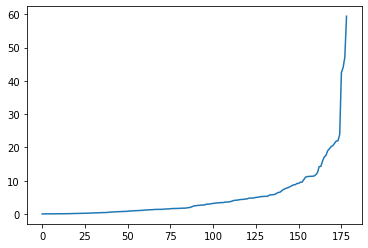

In [91]:
end_times.sort()

plt.figure()
plt.plot(end_times)
plt.show()

In [92]:
end_times

[0.0008101851999526843,
 0.004718750001193256,
 0.00546296301035909,
 0.015737036911887117,
 0.02042824080126593,
 0.026008332818164455,
 0.029085648711770773,
 0.04826388901710743,
 0.050725694032007496,
 0.05155439831069085,
 0.05827268509659911,
 0.061287963351933344,
 0.06864583473361563,
 0.07240740874840412,
 0.07256944454275072,
 0.07387731484050164,
 0.0794097224570578,
 0.10994213395315455,
 0.11396990796492901,
 0.12223148089513416,
 0.13532407487946246,
 0.1430787039716961,
 0.15652777865034295,
 0.16260416725708637,
 0.18734953729290282,
 0.19233518534776506,
 0.216284724912839,
 0.23666666386270663,
 0.23712384393729777,
 0.2550874995457706,
 0.3037152792530833,
 0.31635601976144306,
 0.3340625017081038,
 0.33431713584286626,
 0.3787615761975758,
 0.3839398150215781,
 0.3982986096895182,
 0.42229143523487583,
 0.42530173659419107,
 0.5124074100385769,
 0.5482291702210205,
 0.5805531250443141,
 0.6065740664271289,
 0.6278009269444738,
 0.6684407414449431,
 0.683819499783567

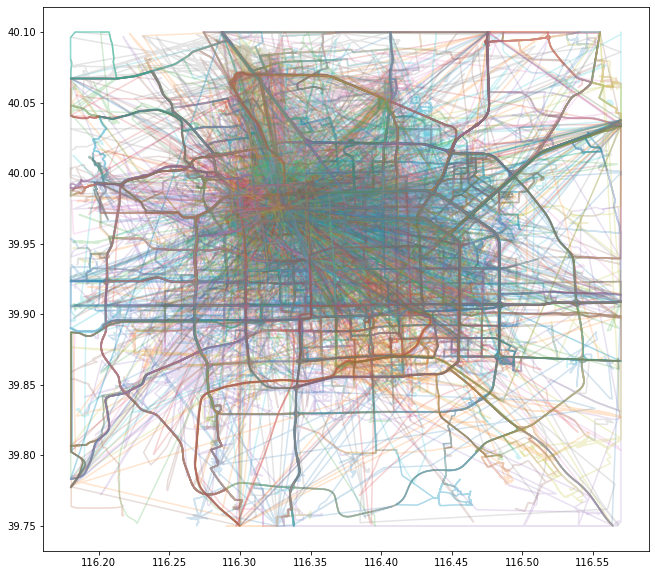

In [93]:
plt.figure(figsize=(18, 10))
plt.gca().set_aspect("equal")
for person_id in big_dict:
    plt.plot(big_dict[person_id]["longitude"], big_dict[person_id]["latitude"], alpha=0.2)
plt.show()

In [98]:
time_grain = []
for person_id in big_dict:
    time_grain.append(big_dict[person_id].mode()["cap_diff"][0])

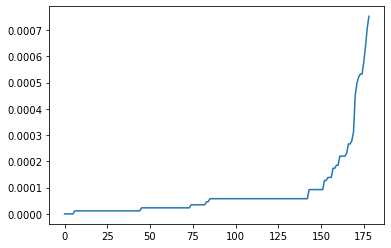

In [99]:
time_grain.sort()

plt.figure()
plt.plot(time_grain)
plt.show()

In [100]:
time_grain

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.157409860752523e-05,
 1.157409860752523e-05,
 1.157409860752523e-05,
 1.157409860752523e-05,
 1.157409860752523e-05,
 1.157409860752523e-05,
 1.157409860752523e-05,
 1.157409860752523e-05,
 1.157409860752523e-05,
 1.157409860752523e-05,
 1.157409860752523e-05,
 1.157409860752523e-05,
 1.157409860752523e-05,
 1.157409860752523e-05,
 1.157409860752523e-05,
 1.157409860752523e-05,
 1.157409860752523e-05,
 1.157409860752523e-05,
 1.157409860752523e-05,
 1.157409860752523e-05,
 1.157409860752523e-05,
 1.157409860752523e-05,
 1.157409860752523e-05,
 1.157409860752523e-05,
 1.157409860752523e-05,
 1.157409860752523e-05,
 1.157409860752523e-05,
 1.157409860752523e-05,
 1.157409860752523e-05,
 1.157409860752523e-05,
 1.157409860752523e-05,
 1.157409860752523e-05,
 1.157409860752523e-05,
 1.157409860752523e-05,
 1.157409860752523e-05,
 1.157409860752523e-05,
 1.157409860752523e-05,
 1.157409860752523e-05,
 1.157409860752523e-05,
 2.3148102627601475e-05,
 2.

Not entirely sure why six of the people usually have 0 second steps. That seems very scuffed. The 1.1574e-05 days translates to 1 second, which is a reasonable time step, I think. Everything else looks pretty ok. I think I can toss everyone into a thicc simulation and have it run overnight to collect all the data. First, we need to convert the position and time information into something that is simulation-friendly.

In [107]:
# convert latitude and longitude to meters and set the lower left corner to be at (0, 0)
lon_min = 116.18
lon_max = 116.57
lat_min = 39.75
lat_max = 40.10

meters_per_degree = 111000 # 1 degree is about 111 km
seconds_per_day = 86400 # 3600*24 seconds in a day

for person_id in big_dict:
    big_dict[person_id]["x"] = (big_dict[person_id]["longitude"] - lon_min) * meters_per_degree
    big_dict[person_id]["y"] = (big_dict[person_id]["latitude"] - lat_min) * meters_per_degree
    big_dict[person_id]["norm_secs"] = big_dict[person_id]["norm_time"] * seconds_per_day


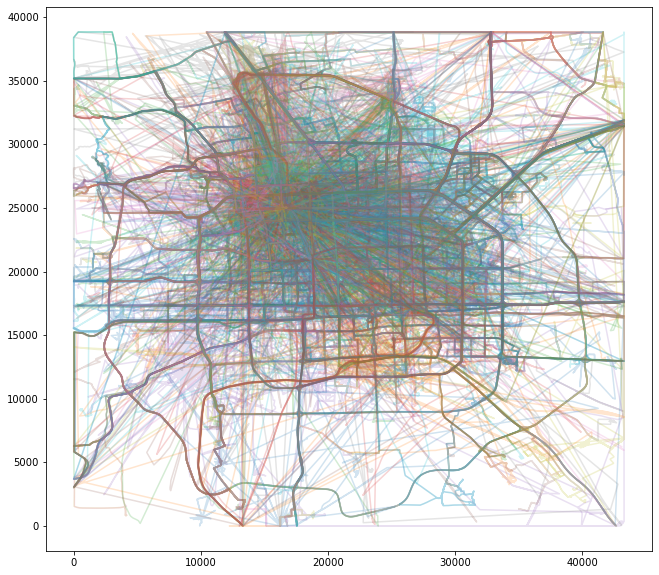

In [109]:
plt.figure(figsize=(18, 10))
plt.gca().set_aspect("equal")
for person_id in big_dict:
    plt.plot(big_dict[person_id]["x"], big_dict[person_id]["y"], alpha=0.2)
plt.show()

In [110]:
print("This takes x from 0 to {} meters and y from 0 to {} meters".format((lon_max-lon_min)*meters_per_degree, (lat_max-lat_min)*meters_per_degree))

This takes x from 0 to 43289.99999999849 meters and y from 0 to 38850.00000000016 meters


Dang this is a large area hahaha. 43290 meters wide and 38850 meters long huh. That's 1,681,816,500 square meters lmao. FML. If we were to place a sensor every, like, 30 sq meters, that would still be over 56 million sensors. And most of them won't even be seen either, since there's so much whitespace on the plot above.

In [111]:
num_samples = 0
for person_id in big_dict:
    num_samples += len(big_dict[person_id])
print(num_samples)

18067760


Alternatively, we can randomly select sensor positions from existing points along the routes. There's only 18 million of those, and we can just do maybe one hundredth of them? Actually, we don't even need a simulation at all lmao. We can just generate sensor positions and radii, do a linear spline of each person's trajectory, and collect times when the person is close to the sensors. It would probably still be useful to have the sensors lie along the routes, so let's do that and see how it goes.

In [116]:
ped_points = []
for person_id in big_dict:
    ped_points += [[x, y] for x, y in zip(big_dict[person_id]["x"], big_dict[person_id]["y"])]
ped_points = np.array(ped_points)

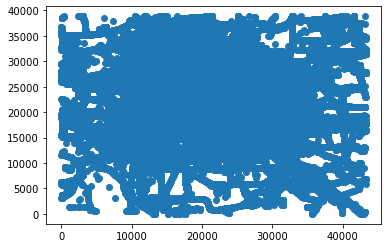

In [119]:
# print out 2 million random points
np.random.shuffle(ped_points)
plt.figure()
plt.scatter(ped_points[:2000000, 0], ped_points[:2000000, 1])

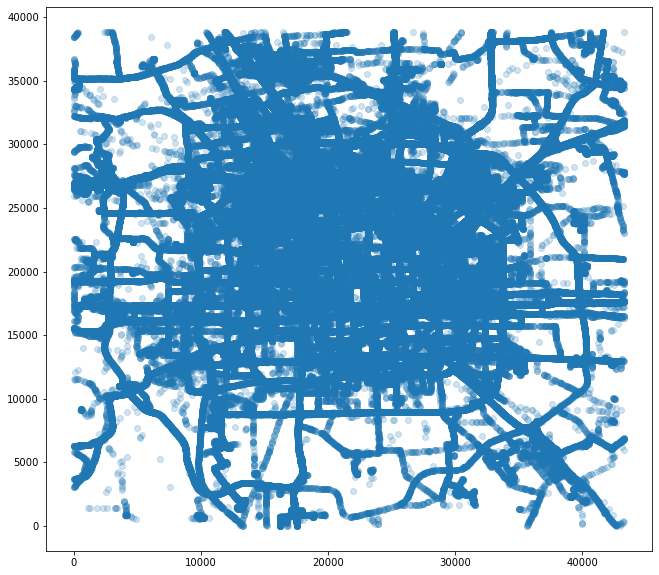

In [122]:
plt.figure(figsize=(18, 10))
plt.gca().set_aspect("equal")
plt.scatter(ped_points[:2000000, 0], ped_points[:2000000, 1], alpha=0.2)
plt.show()

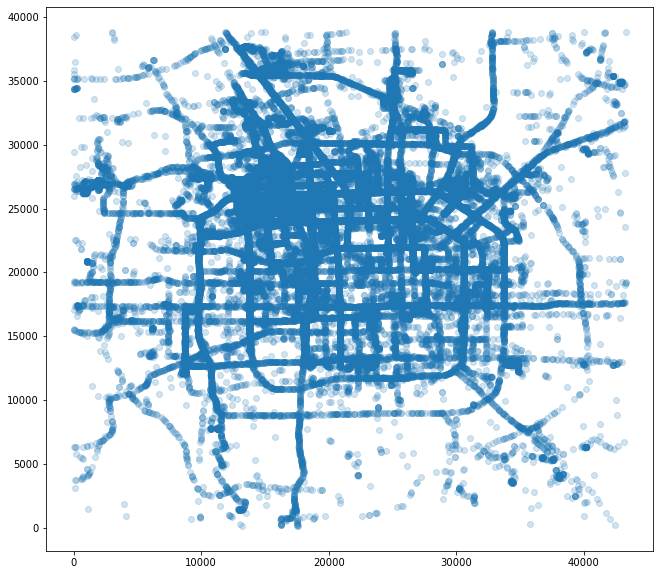

In [123]:
# print out 100 thousand random points
plt.figure(figsize=(18, 10))
plt.gca().set_aspect("equal")
plt.scatter(ped_points[:100000, 0], ped_points[:100000, 1], alpha=0.2)
plt.show()

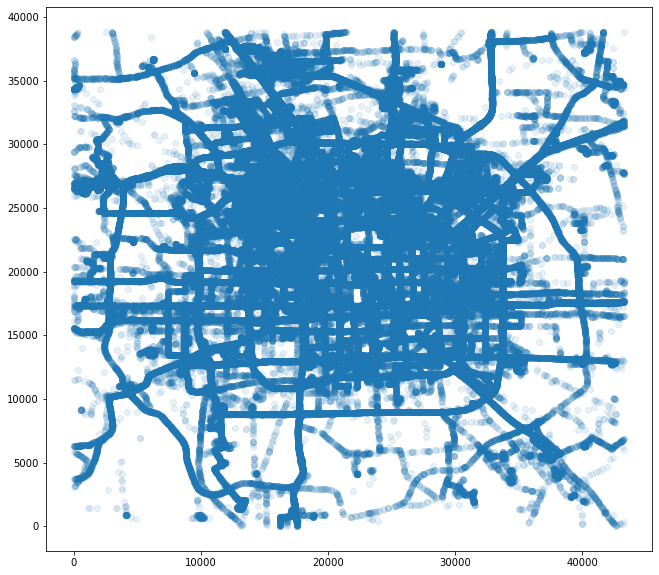

In [125]:
# print out 1 million random points
plt.figure(figsize=(18, 10))
plt.gca().set_aspect("equal")
plt.scatter(ped_points[:1000000, 0], ped_points[:1000000, 1], alpha=0.1)
plt.show()

Ok, let's just do 1 million sensors, because that's a fun number. It's about the same as running into a sensor about once every 20 seconds on average, which is a little ridiculous. Of course, it can be scaled down afterwards, which is why it's somewhat reasonable to do all this processing now. Let's add some noise to the sensor positions really quick and then start processing.

In [131]:
# select our sensor positions and add some random noise
sensor_points = ped_points[:1000000] + np.random.normal(0, 5.0, size=(1000000, 2))

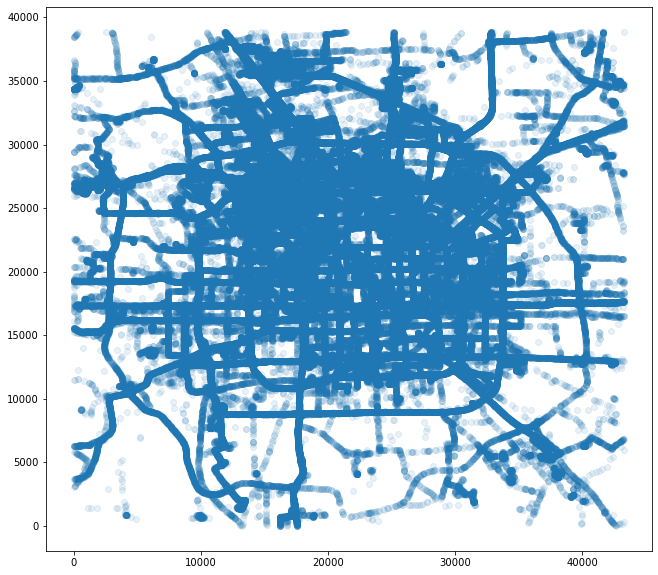

In [132]:
plt.figure(figsize=(18, 10))
plt.gca().set_aspect("equal")
plt.scatter(sensor_points[:, 0], sensor_points[:, 1], alpha=0.1)
plt.show()

In [133]:
# generate the range of these sensors
sensor_radii = np.random.uniform(low=5.0, high=15.0, size=1000000)

Cool. Good enough. Now let's save some ground truth values before we do all our calculations.

## Ground Truth

Save our ground truth of sensor location and radius, and gateway position and time.

In [137]:
# save sensor positions and radii
save_path = "ground_truth/sensors.csv"
with open(save_path, 'w') as save_file:
    save_file.write('sensor ID,x (m),y (m),radius (m)\n')
    for i, coords in enumerate(sensor_points):
        save_file.write('{},{},{},{}\n'.format(i, coords[0], coords[1], sensor_radii[i]))


In [144]:
# save mule positions and times
for person_id in big_dict:
    save_path = "ground_truth/mules/{}.csv".format(person_id)
    with open(save_path, 'w') as save_file:
        save_file.write('x (m),y (m),norm_secs (secs),time (days)\n')
        for x, y, norm_secs, time in zip(big_dict[person_id]["x"], 
                                         big_dict[person_id]["y"],
                                         big_dict[person_id]["norm_secs"],
                                         big_dict[person_id]["time"]):
            save_file.write('{},{},{},{}\n'.format(x, y, norm_secs, time))


In [145]:
# might as well also pickle our dictionary so we don't have to reconstruct it again
# in the future when we realize we messed something up
import pickle

save_path = "ground_truth/big_dict.pkl"
with open(save_path, 'wb') as save_file:
    pickle.dump(big_dict, save_file)


## Simulation Data

Aight here's the strat. For each person, we do a linear spline of *x*, *y*, and *time* with respect to *norm_secs* at a grainularity of 0.5 seconds. At each moment in time, we take the current position of the person, subtract it from the positions of the sensors, and check to see if the person is within range of each sensor. If so, we record the sensor ID and time.

In [ ]:
from scipy.interpolate import interp1d

for person_id in big_dict:
    save_path = "sim_data/mules/{}.csv".format(person_id)
    s = big_dict[person_id]["norm_secs"].to_numpy()
    fx = interp1d(s, big_dict[person_id]["x"].to_numpy())
    fy = interp1d(s, big_dict[person_id]["y"].to_numpy())
    ft = interp1d(s, big_dict[person_id]["time"].to_numpy())
    
    num_samples = int(s[-1] / 0.5)
    s_int = np.linspace(s[0], s[-1], num=num_samples, endpoint=True)
    pos_int = np.vstack([fx(s_int), fy(s_int)]).T
    t_int = ft(s_int)
    
    with open(save_path, 'w') as save_file:
        save_file.write('sensor ID,norm_secs (secs),time (days)\n')
        for i in range(num_samples):
            close_sensors = np.argwhere(np.linalg.norm(sensor_points - pos_int[i], axis=1) < sensor_radii)
            for s_id in close_sensors:
                save_file.write("{},{},{}\n".format(s_id[0], s_int[i], t_int[i]))
        

I believe that's all the simulation data that I need, so I just run this overnight and call it a day!

-- one night later --

Hahaha turns out this code is super slow and clunky! I ran it overnight and it only spit out values for mule 135 and half of 104. I'll move this code to a standalone Python script and use numpy broadcast maths instead of a nested for loop, and hopefully that would work a little bit better. Fingers crossed!

## Scratch work

Everything after this point is just some trial-and-error scratch work that I was using to help myself troubleshoot some of this code.

In [162]:
close_sensors = np.argwhere((sensor_radii - 1) < sensor_radii)
close_sensors

array([[     0],
       [     1],
       [     2],
       ...,
       [999997],
       [999998],
       [999999]])

In [114]:
count = 0
for thiny, poopy in zip(small_df['norm_time'], small_df["cap_diff"]):
    print("{}, {}".format(thiny, poopy))
    if count > 5:
        break
    count += 1

0.0, 0.0
0.003194444398104679, 0.003194444398104679
0.005023148201871663, 0.0018287038037669845
0.006493055603641551, 0.0014699074017698877
0.007731481498922221, 0.0012384258952806704
0.025428240704059135, 0.017696759205136914
0.025717592601722572, 0.00028935189766343683


In [106]:
small_df['norm_time']*3

144     0.000000
145     0.009583
146     0.015069
147     0.019479
148     0.023194
         ...    
136    11.071753
137    11.074080
138    11.078142
139    11.080260
140    11.081059
Name: norm_time, Length: 177, dtype: float64

In [115]:
small_df.head()

latitude   longitude          time  time_diff  cap_diff  norm_time  \
144  39.972967  116.323683  39286.147141        NaN  0.000000   0.000000   
145  39.972917  116.323250  39286.150336   0.003194  0.003194   0.003194   
146  39.973350  116.323600  39286.152164   0.001829  0.001829   0.005023   
147  39.972867  116.324133  39286.153634   0.001470  0.001470   0.006493   
148  39.972900  116.323383  39286.154873   0.001238  0.001238   0.007731   

            x         y   norm_secs  
144  15948.85  24749.30    0.000000  
145  15900.75  24743.75  275.999996  
146  15939.60  24791.85  434.000005  
147  15998.80  24738.20  561.000004  
148  15915.55  24741.90  668.000002

In [143]:
for i, row in enumerate(small_df[["x", "y"]]):
    print(i, row)

0 x
1 y


In [151]:
np.linalg.norm(small_df[["x", "y"]].to_numpy(), axis=1)

array([29443.0580411 , 29412.36159551, 29473.83033443, 29460.82382892,
       29418.80941526, 29368.57665301, 29404.9205435 , 30316.83682875,
       28792.55581515, 29433.83139346, 29415.93743474, 29490.29729267,
       29460.91752087, 29425.37050521, 29458.40138503, 29524.07302768,
       29563.98362097, 29627.47437585, 29668.92181142, 29755.93380832,
       29780.35906854, 29834.0561316 , 29801.21658075, 29775.94264306,
       29723.17576945, 29751.43846579, 29699.71936692, 29648.16262475,
       29548.42389412, 29477.27796662, 29488.66348145, 29432.75493245,
       29436.15278741, 30080.35158282, 29997.33247784, 29932.82854866,
       29857.6273693 , 29731.00005085, 29697.08810656, 29623.41803795,
       29539.74811819, 29475.5080459 , 29422.48863793, 29553.25550449,
       29559.10553979, 29606.90767211, 29714.45697198, 29759.63305192,
       29866.32190432, 29841.95542018, 29900.19483254, 29949.65725649,
       30034.69188476, 30117.87931794, 30145.01072891, 30117.40510778,
      